# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

In [55]:
# Data Scientist Practical Exam: Recipe Site Traffic
# Author: SL
# Submission Date: Mar 30, 2025
# Project Goal: Predict whether a recipe drives high website traffic based on nutritional and category-level attributes.

# ---

# 1. PROJECT OVERVIEW
"""
1. Business Context & Project Overview

Business Goal:

Identify recipes likely to generate high website traffic when featured on the homepage to increase engagement and subscriptions. The product manager expects 80% precision in predicting "high traffic" outcomes.

Project Objective:

Use historical recipe data to train predictive models and evaluate which recipes are most likely to result in high traffic. Recommend a performance metric for ongoing evaluation and business action.
"""

'\n1. Business Context & Project Overview\n\nBusiness Goal:\n\nIdentify recipes likely to generate high website traffic when featured on the homepage to increase engagement and subscriptions. The product manager expects 80% precision in predicting "high traffic" outcomes.\n\nProject Objective:\n\nUse historical recipe data to train predictive models and evaluate which recipes are most likely to result in high traffic. Recommend a performance metric for ongoing evaluation and business action.\n'

In [56]:
# SECTION 1: Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_score
import missingno as msno

sns.set(style="whitegrid")

In [57]:
# SECTION 2: Load and Inspect Data
df = pd.read_csv("recipe_site_traffic_2212.csv")

print("Initial Data Overview:")
print(df.info())
print(df.head())

Initial Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB
None
   recipe  calories  carbohydrate  ...   category  servings high_traffic
0       1       NaN           NaN  ...       Pork         6         High
1       2     35.48         38.56  ...     Potato         4         High
2       3    914.28         42.68  ...  Breakfast         1          NaN
3       4     97.03         30.56  ...  Beverages         4         High
4       5 

### Data Validation Summary

- `recipe`: Unique ID, no missing values or duplicates.
- `calories`, `carbohydrate`, `sugar`, `protein`: 52 rows had all 4 missing, treated as MNAR → dropped.
- `category`: Stripped, grouped rare values (if any), converted to categorical.
- `servings`: Cleaned snack-related noise, cast data type to int.
- `high_traffic`: Cleaned to binary (1 = High, 0 = Low), no missing values.


Missing Percentage by Column:
 high_traffic    39.387540
calories         5.491024
carbohydrate     5.491024
sugar            5.491024
protein          5.491024
recipe           0.000000
category         0.000000
servings         0.000000
dtype: float64


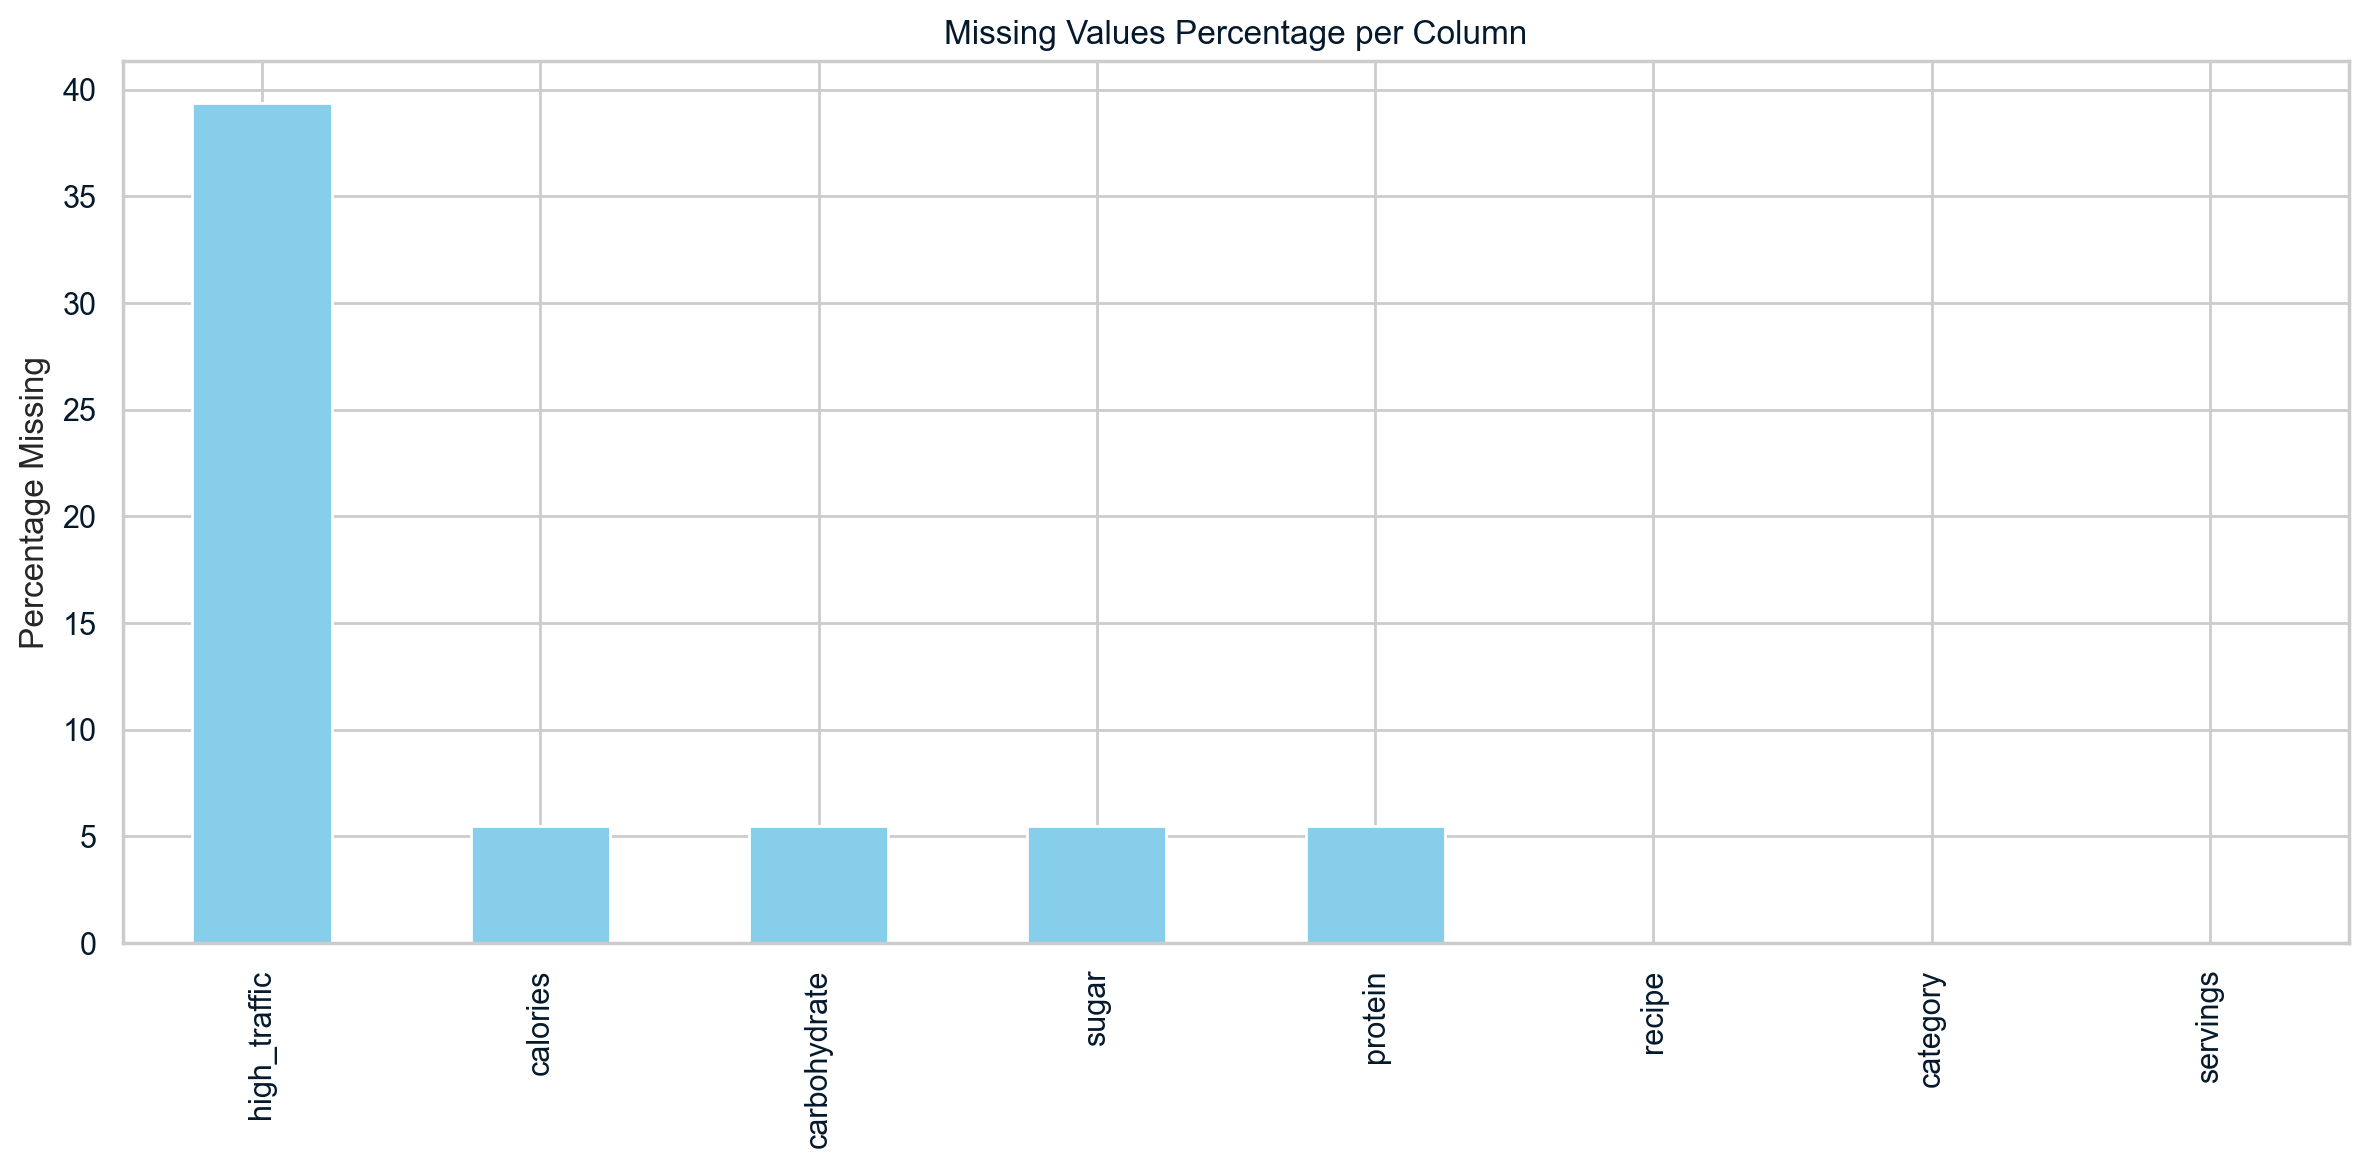

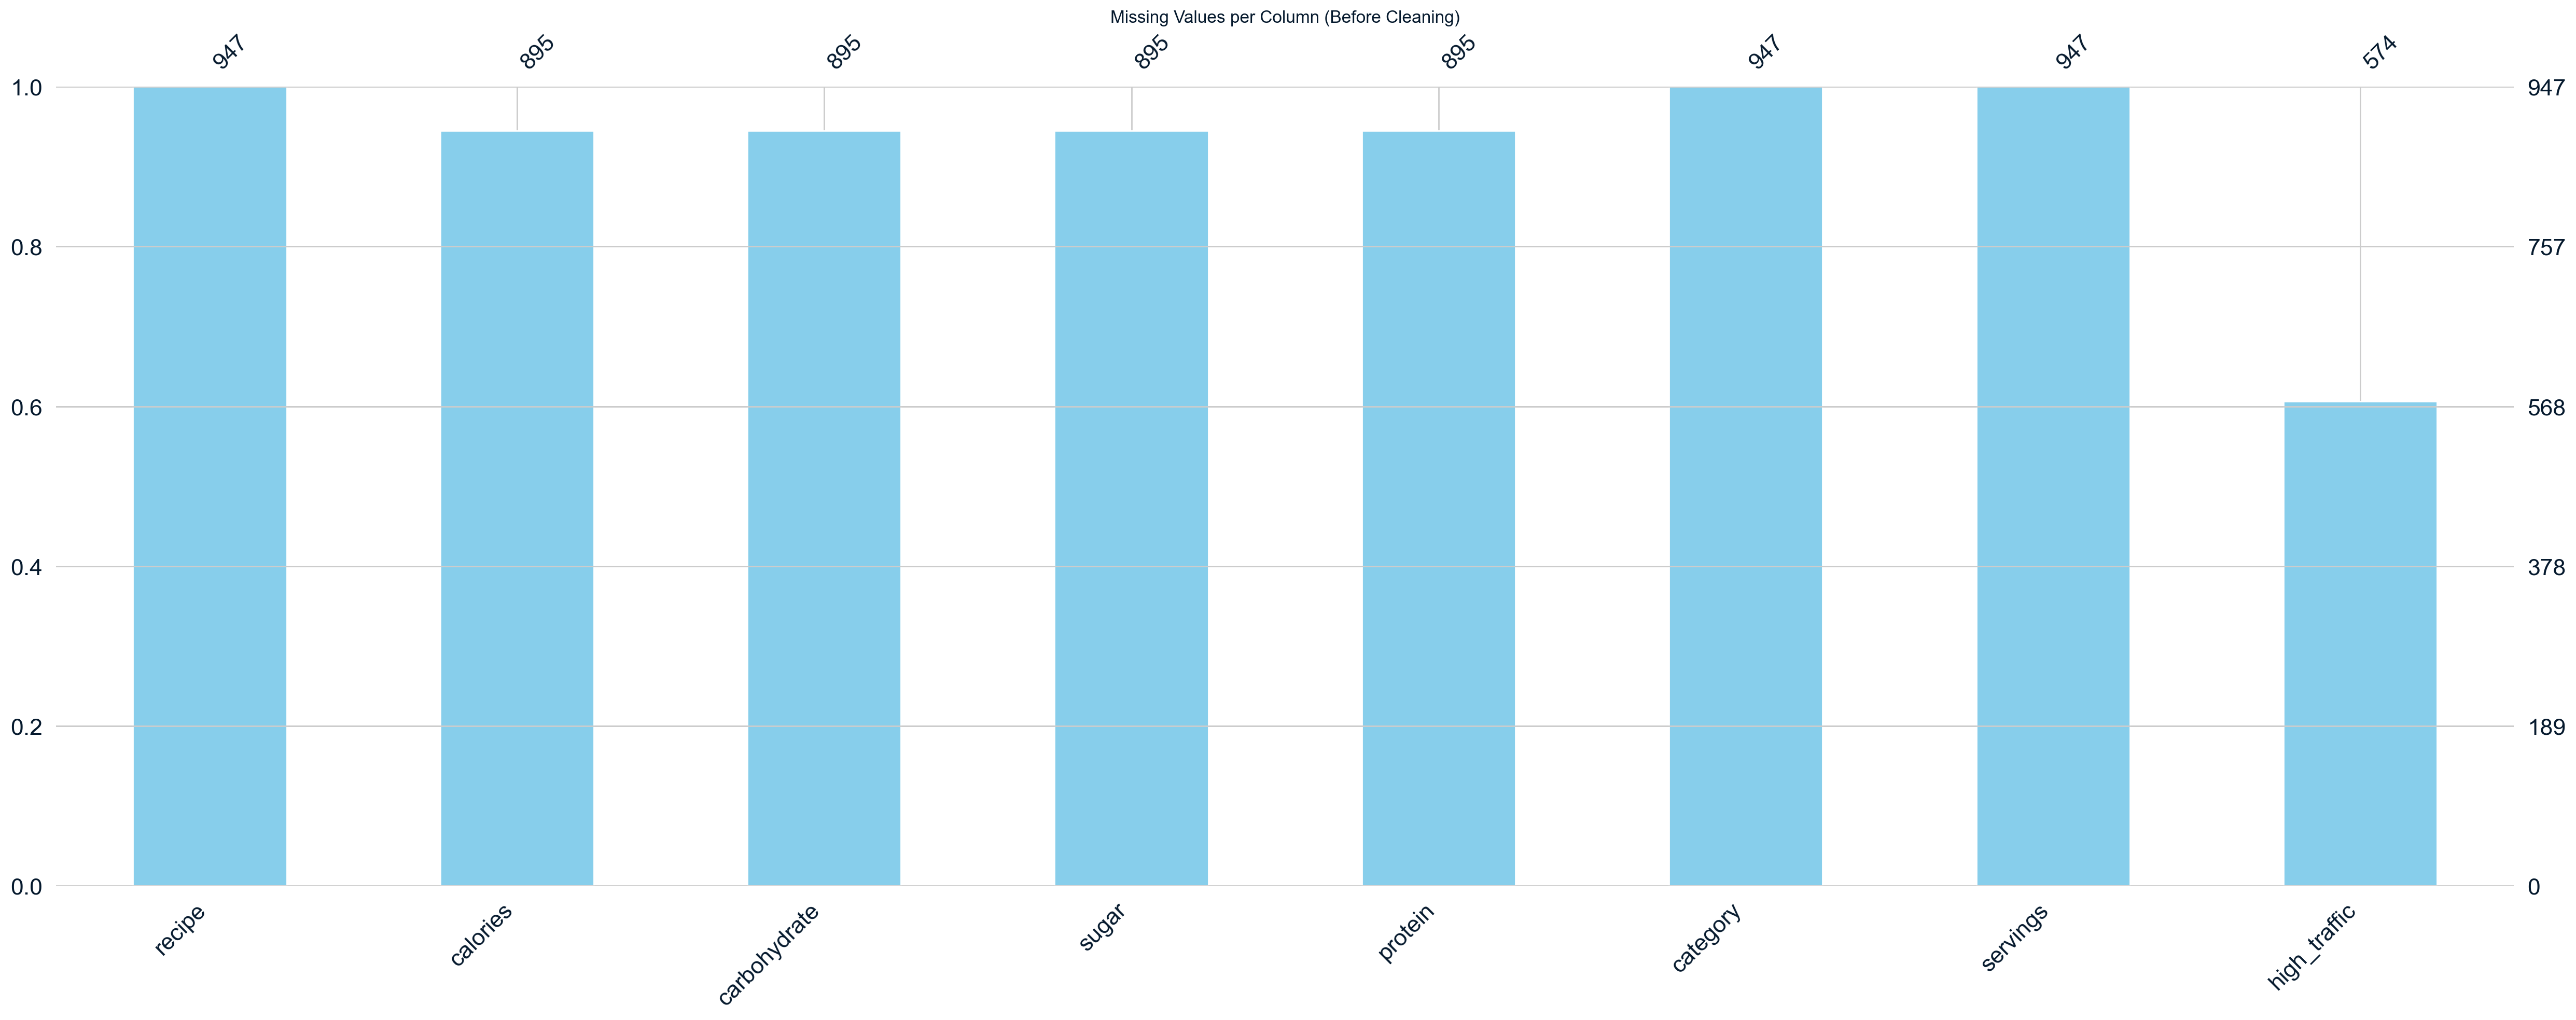

Recipes with ALL nutrition missing (dropped): 52
Final cleaned dataset shape: (895, 8)
✅ Cleaned dataset saved as 'cleaned_recipe_site_traffic.csv'
Total Outliers Detected (Z > 3, category-wise): 73


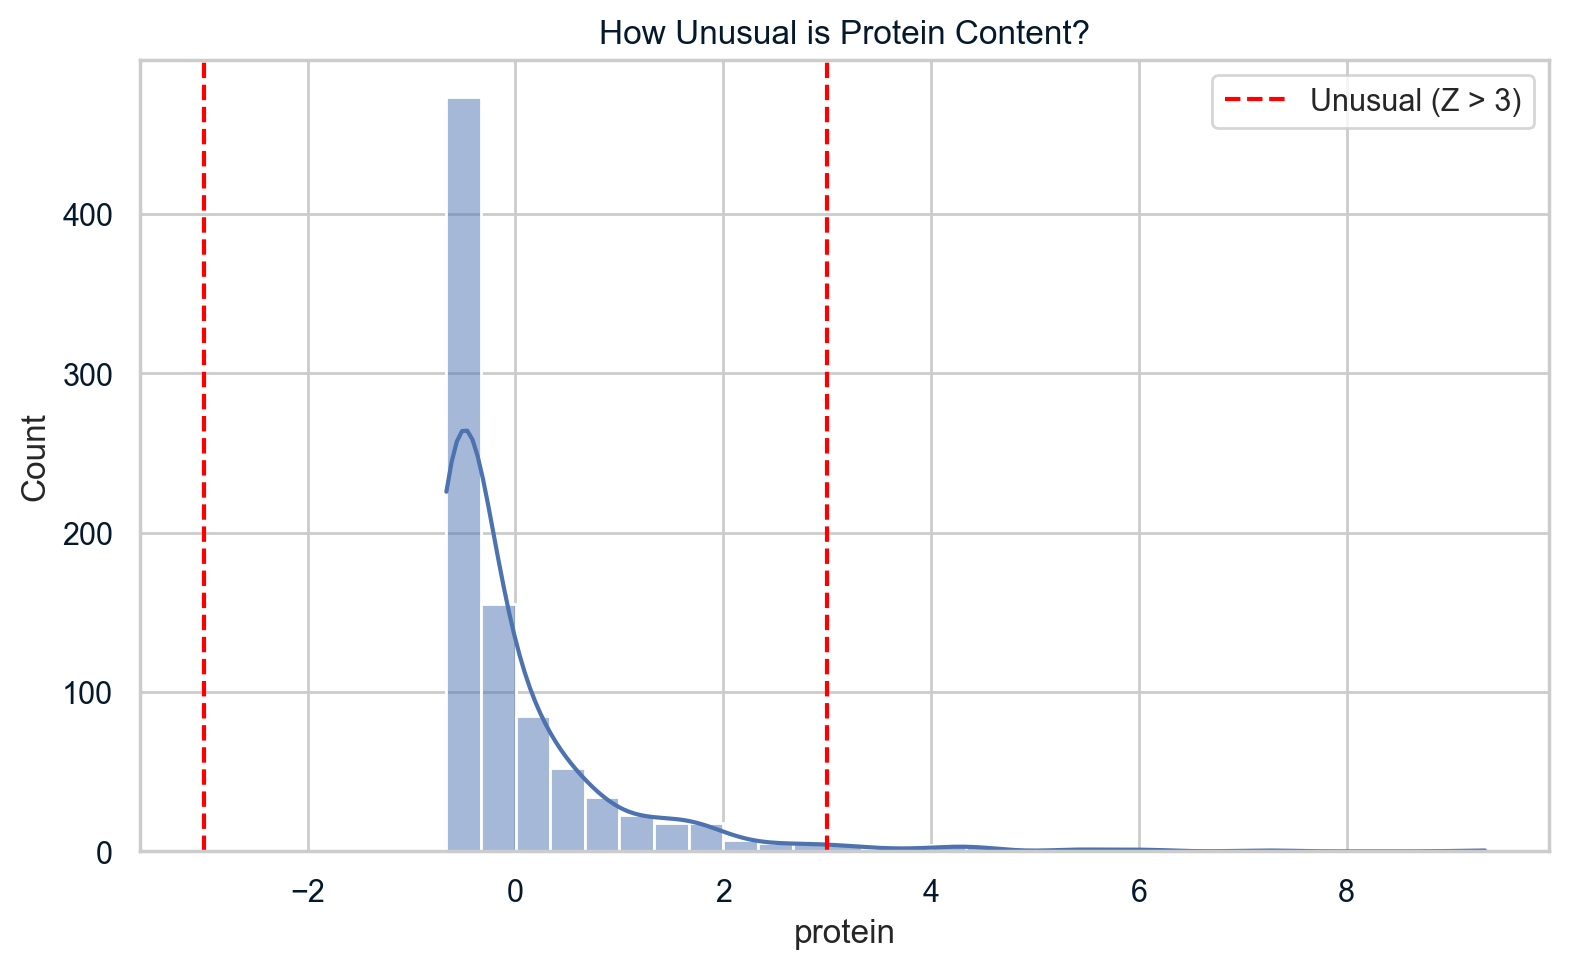

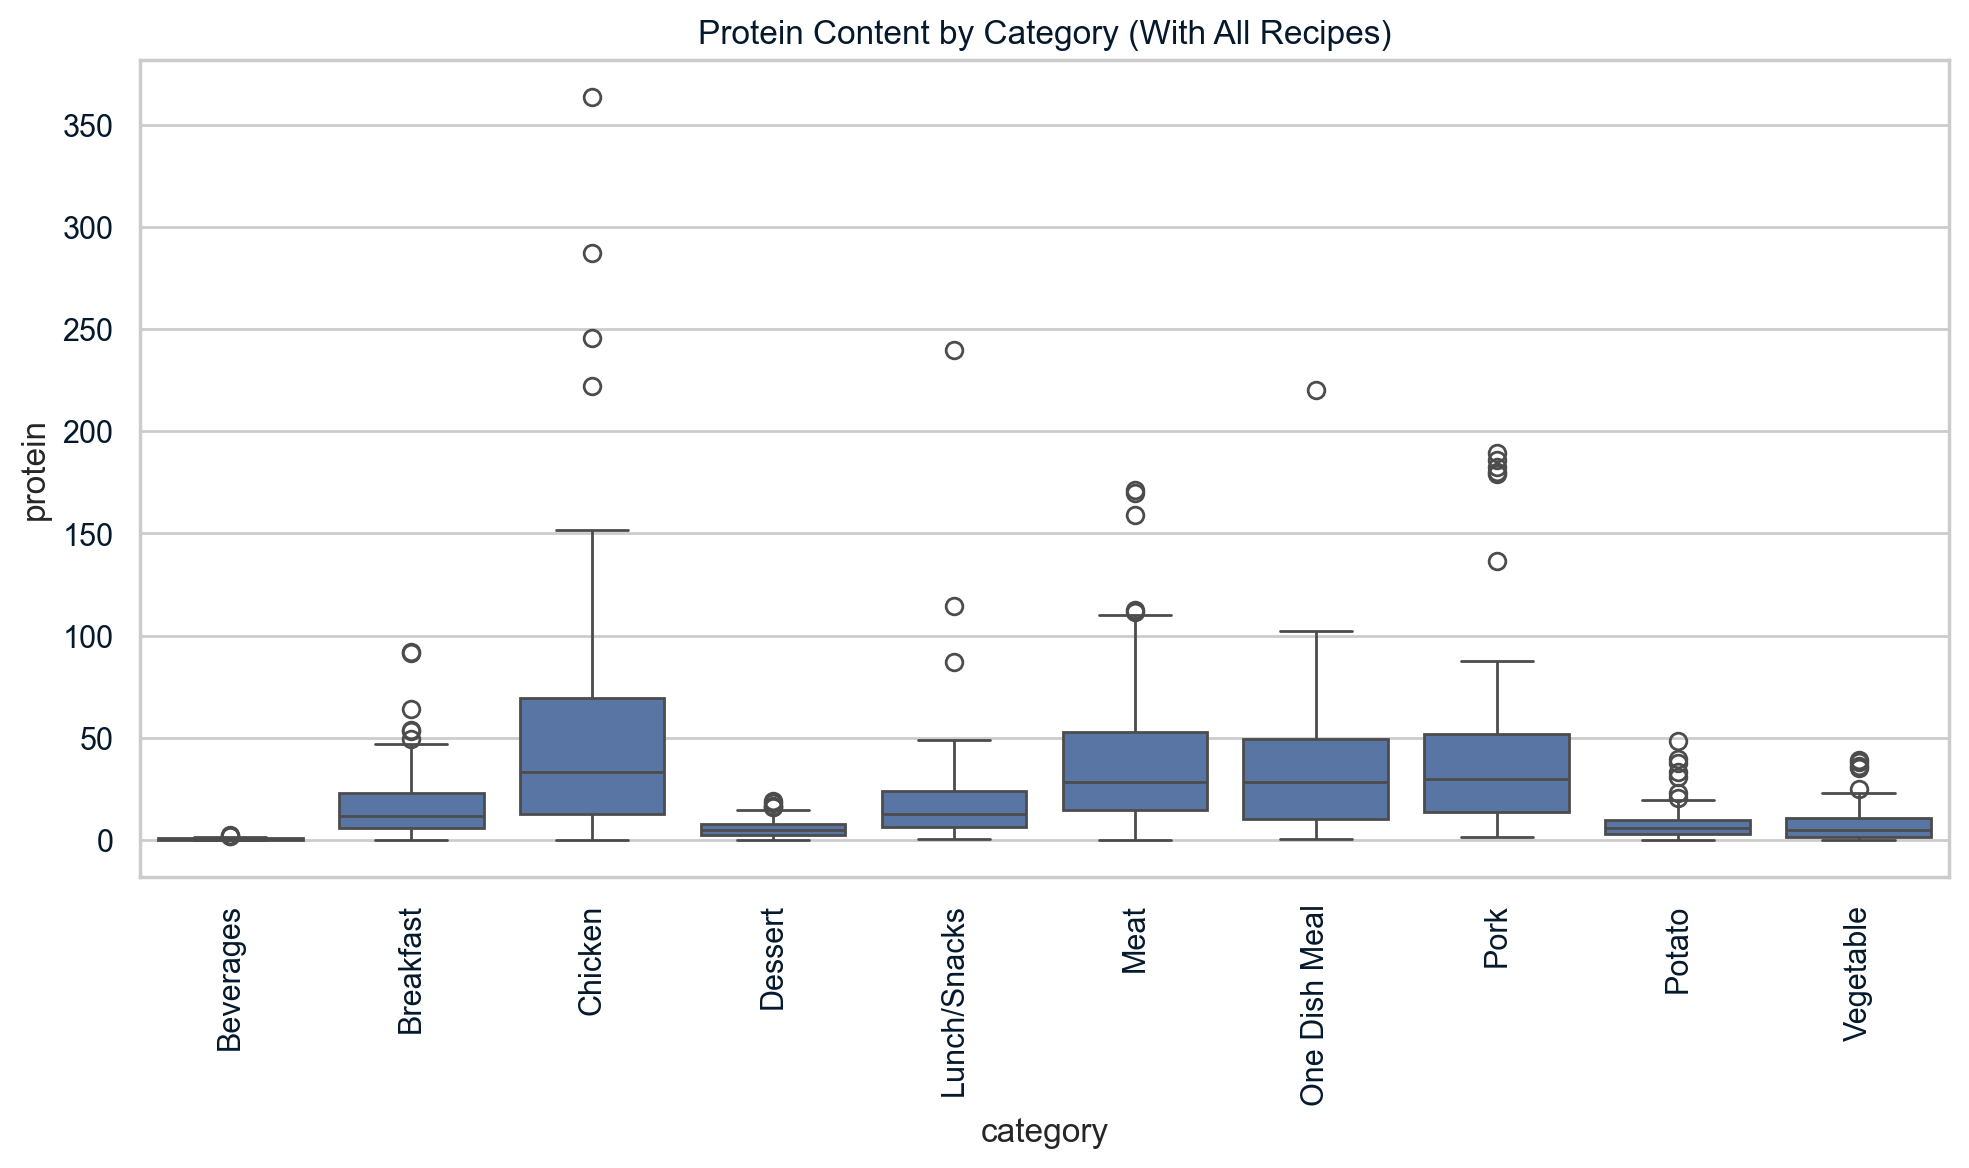

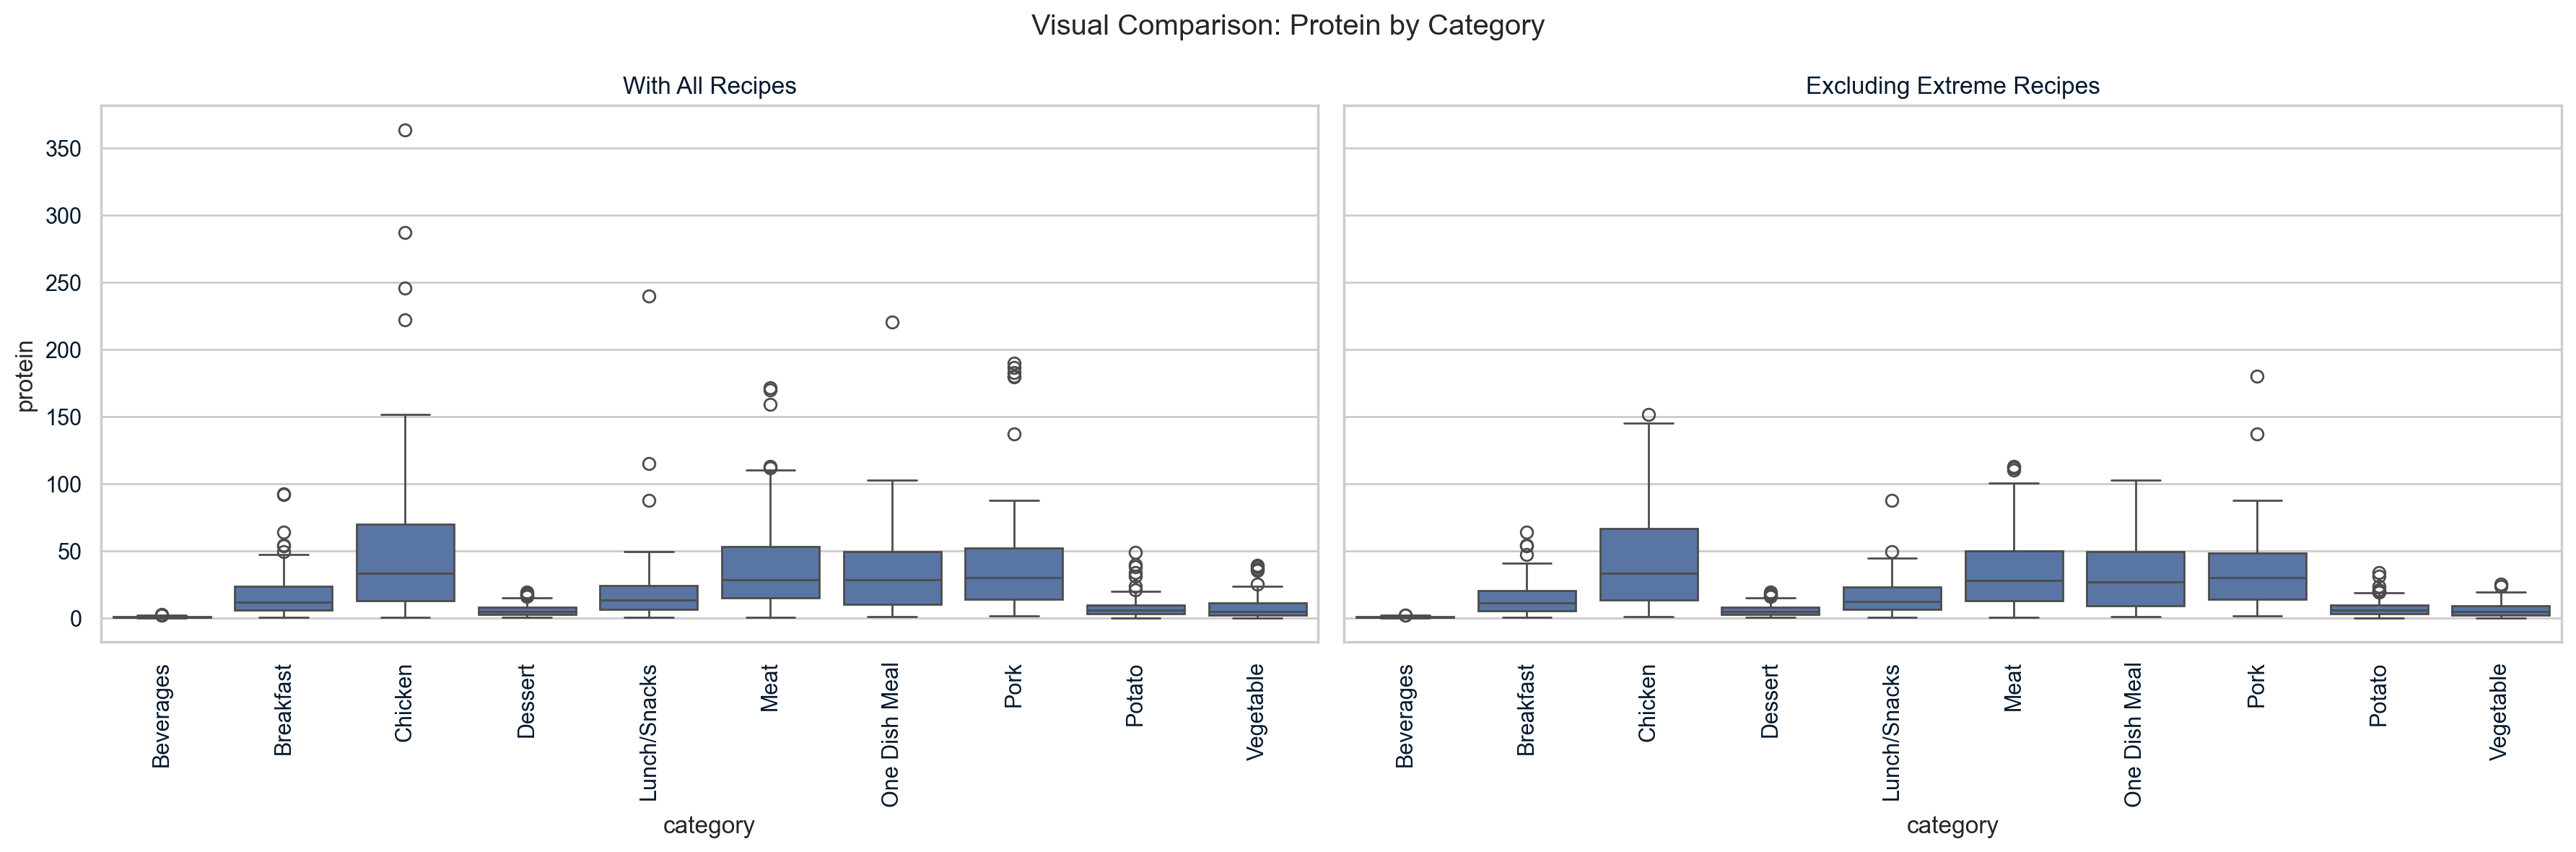

In [58]:
# SECTION 3: Data Validation and Cleaning

# Define key nutritional columns
nutritional_cols = ['calories', 'carbohydrate', 'sugar', 'protein']

# 1. Check and visualize missing values
missing_summary = df.isnull().mean().sort_values(ascending=False) * 100
print("Missing Percentage by Column:\n", missing_summary)

plt.figure(figsize=(12, 6))
missing_summary.plot(kind='bar', color='skyblue')
plt.ylabel("Percentage Missing")
plt.title("Missing Values Percentage per Column")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
msno.bar(df, color='skyblue')
plt.title("Missing Values per Column (Before Cleaning)")
plt.tight_layout()
plt.show()

# 2. Drop rows missing ALL nutritional values
# Dropped rows with all nutrition missing (MNAR)
fully_missing_nutrition = df[nutritional_cols].isnull().all(axis=1).sum()
print(f"Recipes with ALL nutrition missing (dropped): {fully_missing_nutrition}")
df.dropna(subset=nutritional_cols, how='all', inplace=True)

# 3. Impute remaining missing values using grouped median by ['category', 'servings']
df[nutritional_cols] = df.groupby(['category', 'servings'])[nutritional_cols]\
                         .transform(lambda x: x.fillna(x.median()))

# 4. Clean and standardize 'servings' column: turn "4 as a snack" into just 4, turn "6 as a snack" into just 6
df['servings'] = df['servings'].replace({
    "4 as a snack": "4", 
    "6 as a snack": "6"
}).astype(int)

# 5. Clean up 'category' column, simplify categories like 'Chicken Breast' to 'Chicken' for consistency
df['category'] = df['category'].str.replace(" Breast", "").str.strip().astype('category')

# 6. Encode and clean the binary target column "High" traffic → 1
# Convert the target column into numbers for modeling: 'high_traffic'  (1 = high, 0 = low), "Low" traffic or missing values (NaN) → 0 (assume low traffic if missing values)
df['high_traffic'] = df['high_traffic'].fillna("low")\
                                       .astype(str).str.strip().str.lower()\
                                       .map({"high": 1, "low": 0})

# 7. Remove any identical duplicate rows (if accidentally repeated)
df.drop_duplicates(inplace=True)

# ✅ Show how many rows and columns we have after cleaning
print(f"Final cleaned dataset shape: {df.shape}")

# Save cleaned data for consistent model input later
df.to_csv("cleaned_recipe_site_traffic.csv", index=False)
print("✅ Cleaned dataset saved as 'cleaned_recipe_site_traffic.csv'")


# SECTION 4: Outlier Detection and Justification

# We want to spot extreme values (like super high protein) that might still matter for the modeling

# 1. Compute category-wise Z-scores for nutritional columns
# For each category (like "Pork" or "Vegetable"), calculate how unusual the nutrition values are
z_scores_grouped = df.groupby('category')[nutritional_cols].transform(lambda x: np.abs(zscore(x)))

# 2. Flag rows where any Z-score > 3 (i.e., outlier in that column)
# Mark a recipe as "unusual" if any of its nutrition values are way off (> 3 standard deviations)
outliers = (z_scores_grouped > 3).any(axis=1)
total_outliers = outliers.sum()
print(f"Total Outliers Detected (Z > 3, category-wise): {total_outliers}")

# 3. We KEEP outliers for modeling due to (We’re keeping all recipes, even extreme ones, because):
# - Small dataset size (~895 rows (recipes))
# - Tree-based models are robust to outliers
# - These values may represent rare but valid real-world recipes
# - Removing them risks losing signal for high-traffic prediction
# - These "unusual" recipes could still bring high traffic
# - Our models (like Random Forest) can handle them

# Optional: create filtered copy (for visualization only)
# Save a version of the data without the extreme recipes (used just for comparison)
df_no_outliers = df[~outliers].copy()

# Plot 1: Show how "unusual" protein values are distributed
plt.figure(figsize=(8, 5))
sns.histplot(zscore(df['protein'].dropna()), bins=30, kde=True)
plt.axvline(3, color='red', linestyle='--', label='Unusual (Z > 3)')
plt.axvline(-3, color='red', linestyle='--')
plt.title("How Unusual is Protein Content?")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Protein by category (including extreme values)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='category', y='protein')
plt.xticks(rotation=90)
plt.title("Protein Content by Category (With All Recipes)")
plt.tight_layout()
plt.show()

# Plot 3: Side-by-side comparison — with and without outliers
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

sns.boxplot(data=df, x='category', y='protein', ax=axes[0])
axes[0].set_title("With All Recipes")
axes[0].tick_params(axis='x', rotation=90)

sns.boxplot(data=df_no_outliers, x='category', y='protein', ax=axes[1])
axes[1].set_title("Excluding Extreme Recipes")
axes[1].tick_params(axis='x', rotation=90)

plt.suptitle("Visual Comparison: Protein by Category")
plt.tight_layout()
plt.show()

# Summary 
# Cleaned all columns so data is consistent and usable.
# Converted "high traffic" to 1/0 for modeling.
# Found a few extreme recipes (like very high protein), but kept them — they might actually be high traffic recipes.
# Visuals confirm that some categories vary a lot in nutrients, which could impact traffic.

In [59]:
# # SECTION 5: Visualizations

# # 1. Z-score distribution for 'protein'
# plt.figure(figsize=(8, 5))
# sns.histplot(zscore(df['protein'].dropna()), bins=30, kde=True)
# plt.axvline(3, color='red', linestyle='--', label='Z = 3')
# plt.axvline(-3, color='red', linestyle='--')
# plt.title("Z-Score Distribution for Protein")
# plt.legend()
# plt.tight_layout()
# plt.show()

# # 2. Boxplot: Protein by Category (With Outliers)
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=df, x='category', y='protein')
# plt.xticks(rotation=90)
# plt.title("Protein by Category (Boxplot With Outliers)")
# plt.tight_layout()
# plt.show()

# # 3. Side-by-side Boxplot Comparison (With vs Without Outliers)
# fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# sns.boxplot(data=df, x='category', y='protein', ax=axes[0])
# axes[0].set_title("With Outliers")
# axes[0].tick_params(axis='x', rotation=90)

# sns.boxplot(data=df_no_outliers, x='category', y='protein', ax=axes[1])
# axes[1].set_title("Without Outliers")
# axes[1].tick_params(axis='x', rotation=90)

# plt.suptitle("Protein Distribution by Category (With vs Without Outlier Removal)")
# plt.tight_layout()
# plt.show()

Summary for Report or Slide:

Outlier Handling Strategy:
We detected 73 outliers (recipes) using Z-score > 3 across nutritional columns, grouped by recipe category.
Given the limited dataset (~895 rows), we kept outliers to preserve data variability, retain real-world edge cases, and enhance model robustness — especially for tree-based classifiers like Random Forest or XGBoost.

We found 73 recipes with unusually high or low nutrient values compared to others in their category. These recipes were not removed because:

They may reflect real and popular recipes that are different but valid.
Our dataset is relatively small (~895 rows), so every recipe counts.
Our prediction models (like Random Forest) are designed to handle unusual values well.
Removing these could hide important patterns behind what makes some recipes go viral.

Bottom Line:
We kept all recipes to make the model smarter and more inclusive, especially for standout or niche dishes that could still drive high traffic.


In [60]:
# Column-wise Validation and Cleaning Summary

# recipe (numeric, unique ID):
# - Acts as a unique identifier for each recipe.
# - No missing values or duplicates, so we kept it as-is.

# calories, carbohydrate, sugar, protein (numerical nutritional values):
# - Some values were missing.
# - We filled in the blanks using the **median from similar recipes** (same category and servings).
# - This keeps the data realistic without copying from unrelated dishes.
# - Grouped imputation maintains nutritional context (e.g., 1-serving dish not treated like 6-serving dish).
# - This approach prevents bias introduced by global median imputation.

# category (categorical, recipe type, e.g., "Pork", "Vegetables"):
# - Standardized text formatting: stripped whitespace, corrected mislabeled values (e.g., removed " Breast").
# - Converted to 'category' dtype to optimize memory and improve preprocessing pipeline performance.

# servings (mixed type: text + numeric):
# - Normalized entries like "4 as a snack" → 4.
# - Converted all servings to integers for consistency in modeling and grouping.

# high_traffic (target variable– was the recipe popular (high traffic?):
# - Missing values filled as "low", assuming non-engagement by default.
# - Standardized text (case-insensitive), mapped to binary values: {"high": 1, "low": 0}.

# Explicit duplicate check
# - Checked for and removed any duplicate rows (none were found in this case).
print("Duplicates:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

# Final null check after cleaning
print("Missing values after cleaning:")
print(df.isnull().sum())


Duplicates: 0
Missing values after cleaning:
recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64


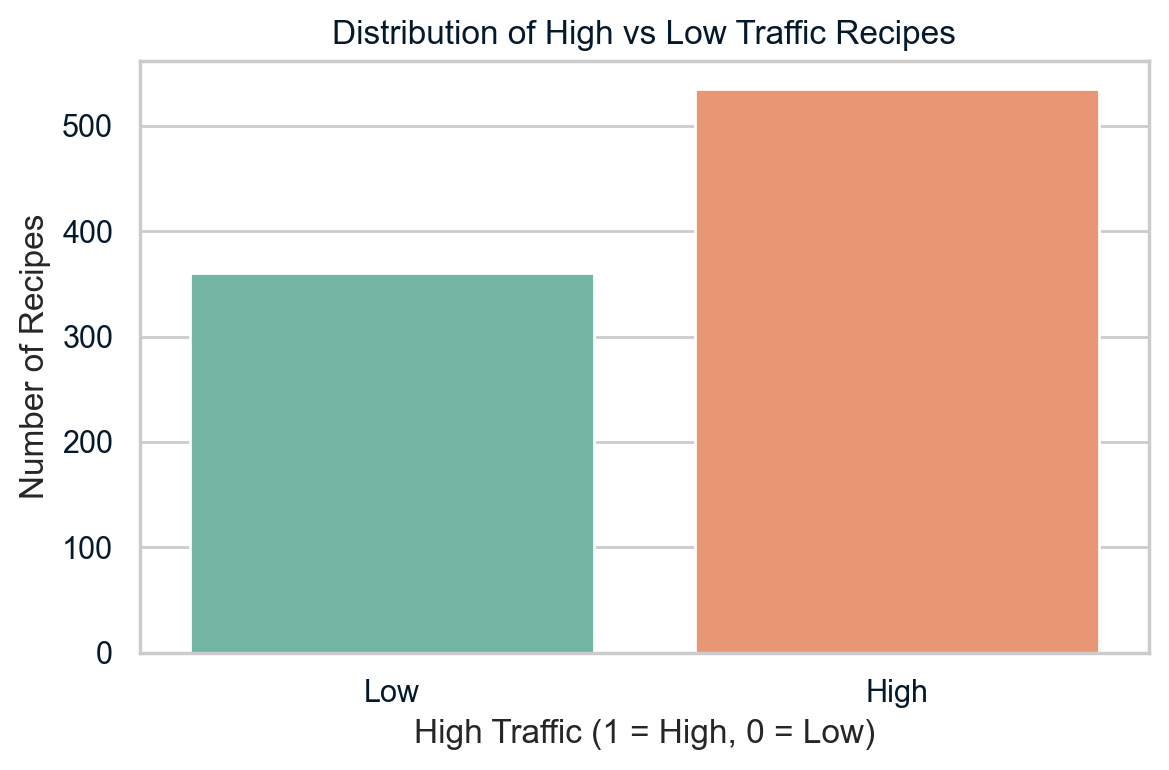

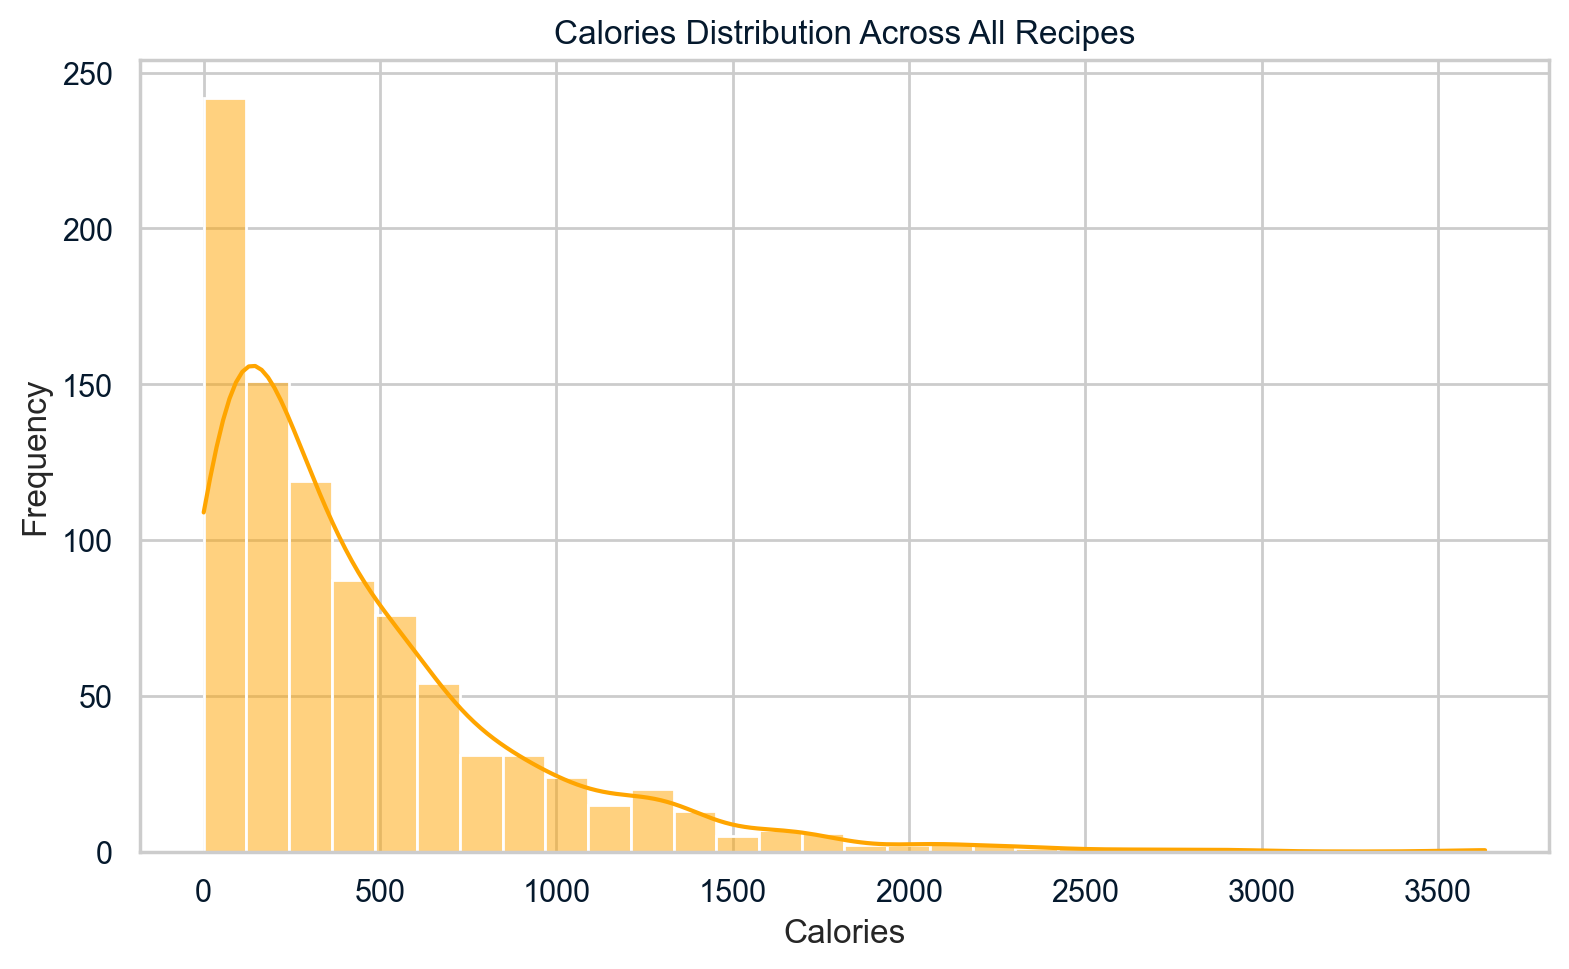

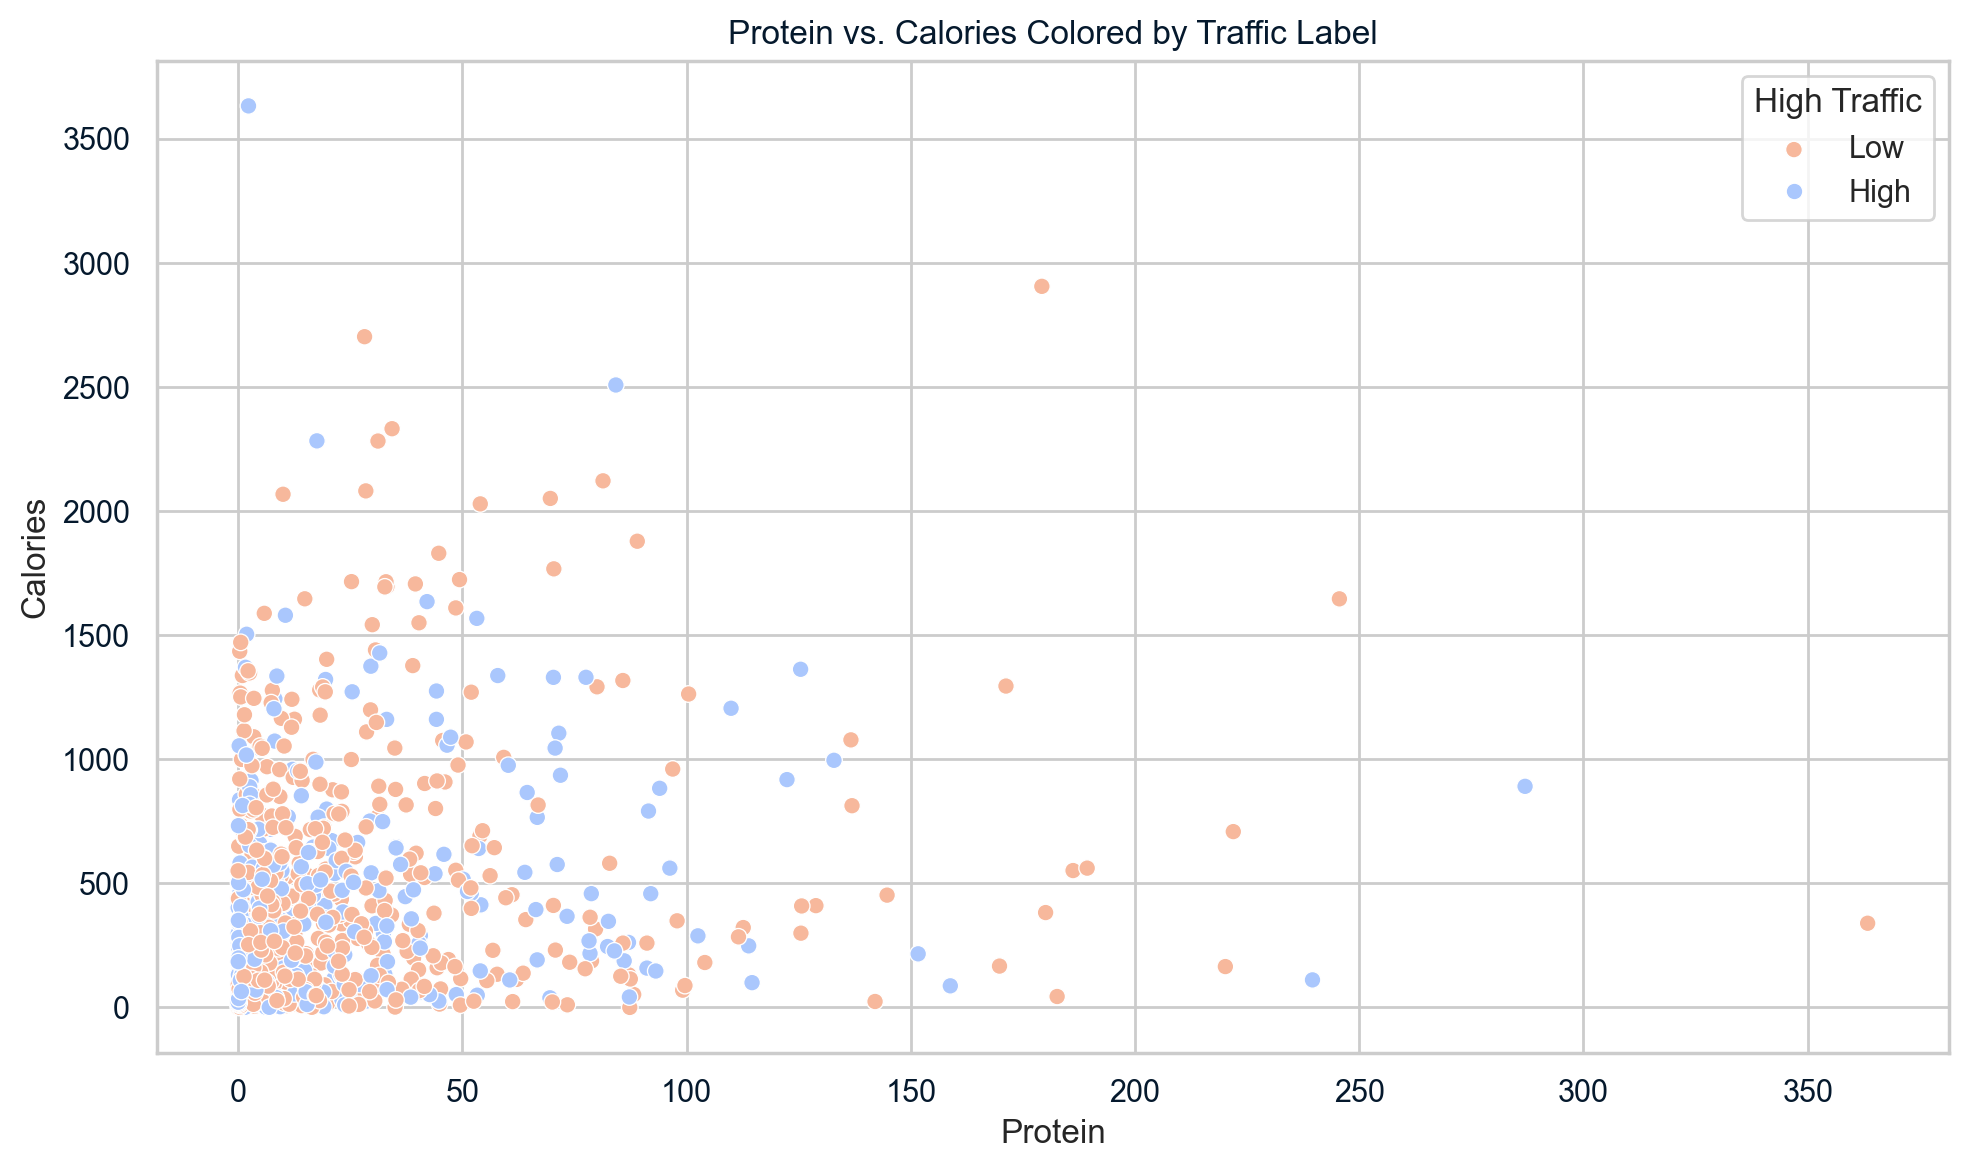

In [61]:
# =====================
# SECTION 6: Exploratory Data Analysis (EDA)
# =====================

import matplotlib.ticker as mtick

# 🔹 Graph 1: Target distribution (binary classification balance)
# Shows the count of recipes classified as high or low traffic.
# Helps assess target variable balance before model training.

plt.figure(figsize=(6, 4))
sns.countplot(x='high_traffic', data=df, palette='Set2')
plt.title("Distribution of High vs Low Traffic Recipes")
plt.xlabel("High Traffic (1 = High, 0 = Low)")
plt.ylabel("Number of Recipes")
plt.xticks([0, 1], ['Low', 'High'])
plt.tight_layout()
plt.show()

# 🔹 Graph 2: Calories distribution (checking skewness)
# Visualizes the calorie distribution across all recipes.
# Important for checking skewness and determining if transformations (e.g. log) are needed.

plt.figure(figsize=(8, 5))
sns.histplot(df['calories'], kde=True, bins=30, color='orange')
plt.title("Calories Distribution Across All Recipes")
plt.xlabel("Calories")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 🔹 Graph 3: Protein vs. Calories, colored by target variable
# Scatter plot of protein vs. calories, colored by traffic label.
# Helps spot potential relationships and patterns between nutrients and traffic labels.

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='protein', y='calories', hue='high_traffic', palette='coolwarm')
plt.title("Protein vs. Calories Colored by Traffic Label")
plt.xlabel("Protein")
plt.ylabel("Calories")
plt.legend(title='High Traffic', labels=['Low', 'High'])
plt.tight_layout()
plt.show()

#### Bar Plot: High vs Low Traffic Count
- Audience: Product Manager
- Insights Summary:
    1. The dataset is moderately balanced, with more high-traffic recipes.
    2. Ensures that class imbalance won’t heavily bias the model.

#### Histogram: Calories Distribution
- Audience: Head of DS
- Insights Summary:
    1. Calories are heavily right-skewed, indicating that log transformation may improve model performance.

#### Scatterplot: Protein vs. Calories Colored by Traffic Label
- Audience: Both (Product + Data Science Teams)
- Insights Summary:
    1. Target distribution is moderately balanced, with slightly more high-traffic recipes.
    2. Calories are heavily right-skewed, indicating need for possible transformation.
    3. High-traffic recipes tend to have higher protein content, especially in the 30g+ range.
        ➤ Suggests protein could be a strong predictor of recipe popularity.

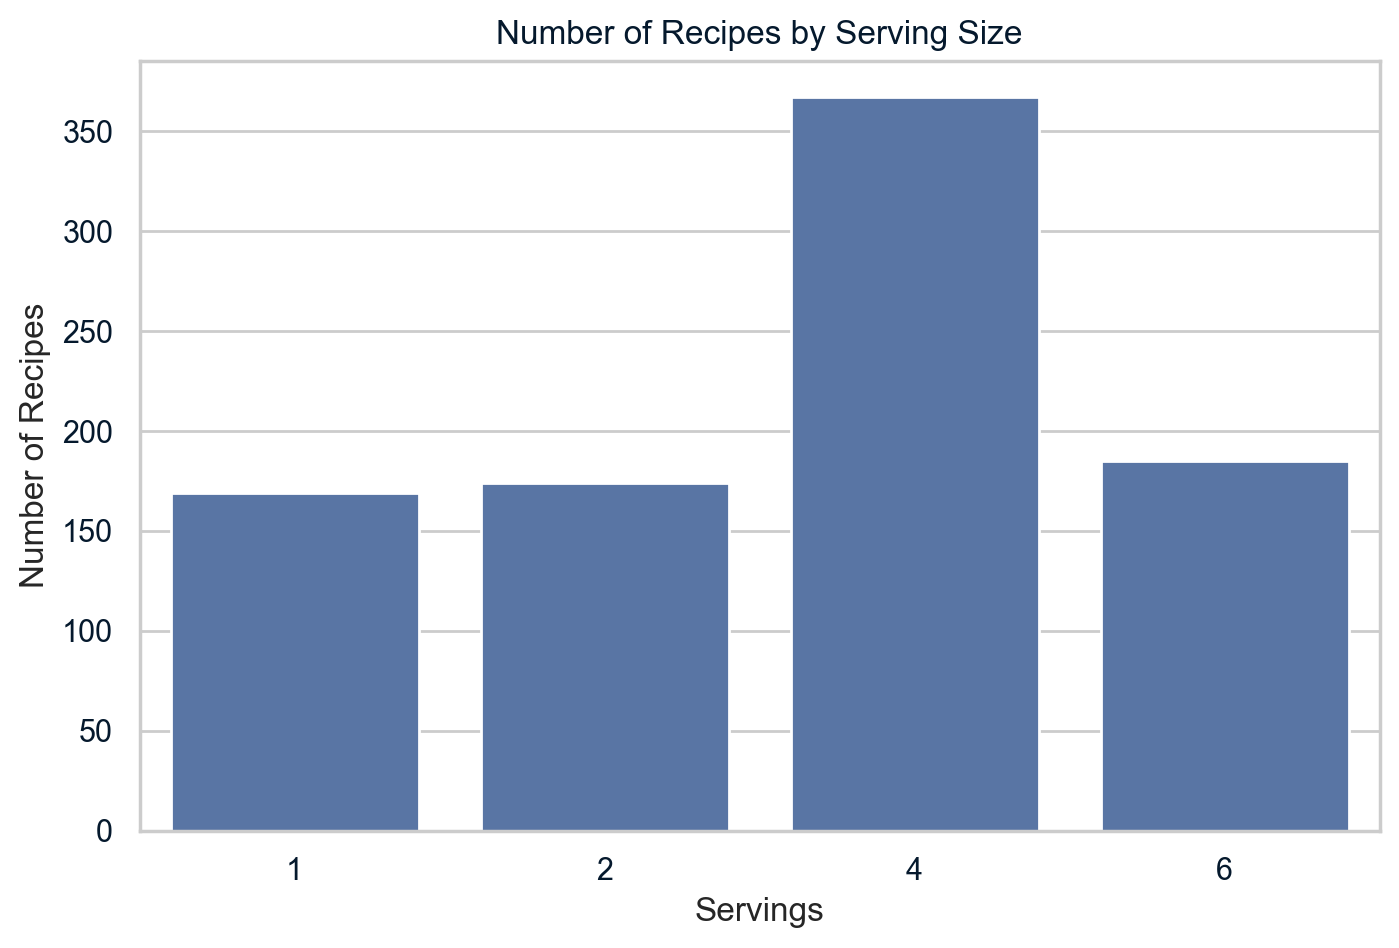

In [62]:
# Number of Recipes by Servings

plt.figure(figsize=(8,5))
sns.countplot(data=df, x='servings')
plt.title('Number of Recipes by Serving Size')
plt.xlabel('Servings')
plt.ylabel('Number of Recipes')
plt.show()


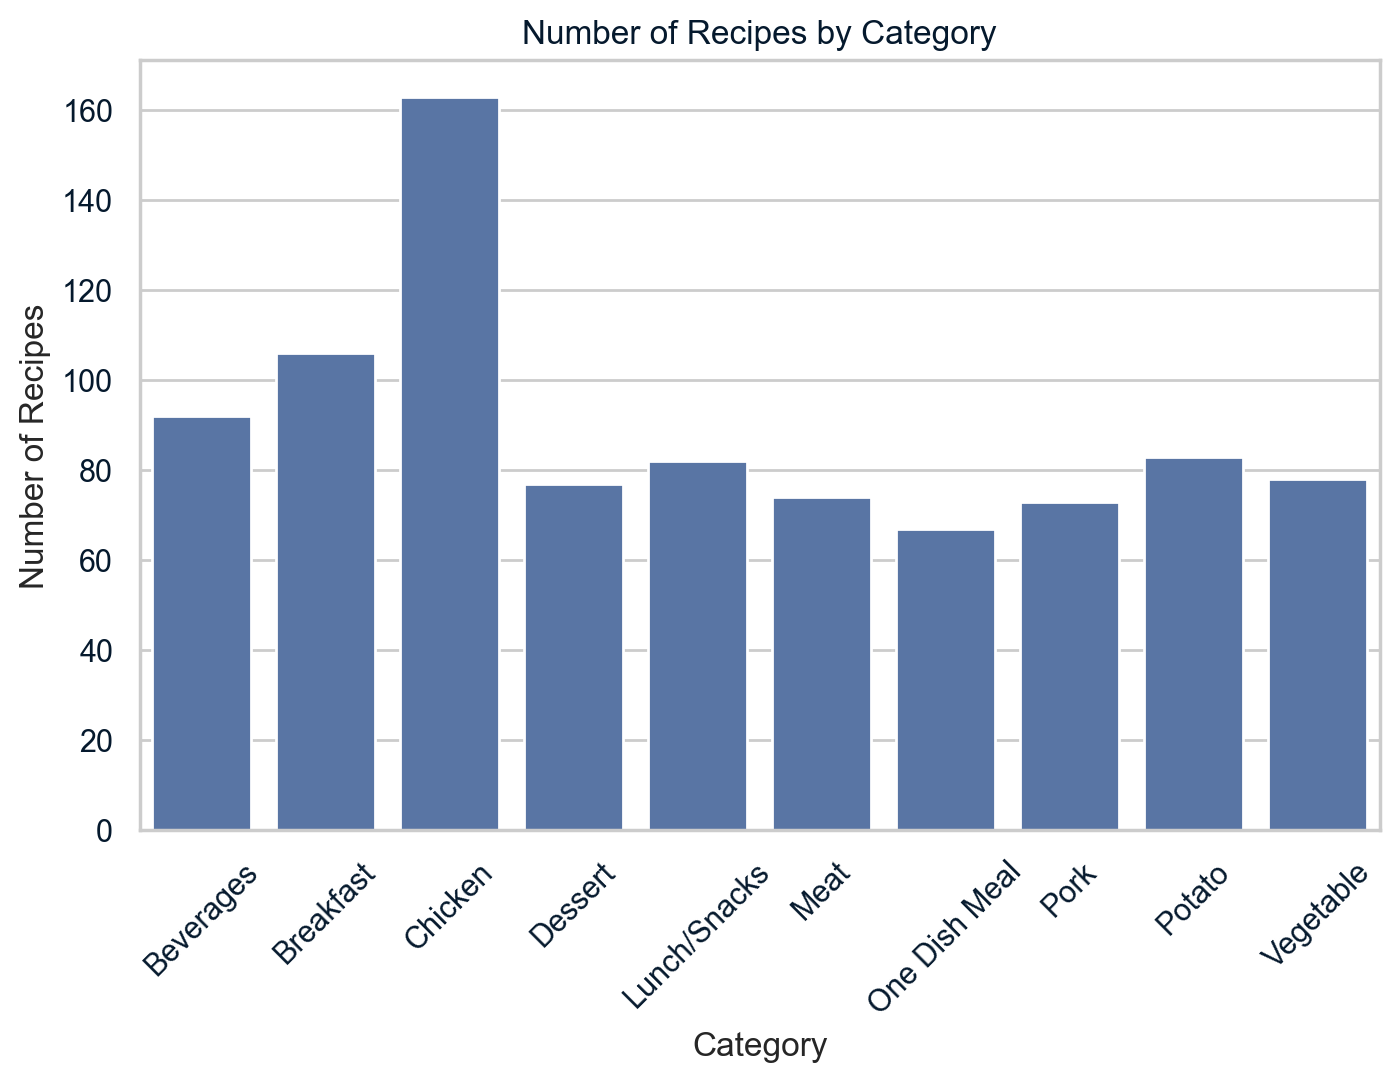

In [63]:
# Number of Recipes by Category

plt.figure(figsize=(8,5))
sns.countplot(data=df, x='category')
plt.title('Number of Recipes by Category')
plt.xlabel('Category')
plt.ylabel('Number of Recipes')
plt.xticks(rotation=45)
plt.show()


The plots above highlight the distribution of recipes across serving sizes and categories.

- **Servings:** Most recipes are designed for 4 servings, making it the dominant group. Single, double, and 6-person servings show similar but smaller counts, indicating less variety or lower popularity.
- **Categories:** Chicken recipes are the most popular, which could indicate a strong customer interest in chicken dishes. Other categories like breakfast, beverages, and desserts also show decent variety, while one-dish meals and pork are less common.

🔑 **Insight:** Understanding the distribution of servings and categories helps identify key areas for marketing focus, recipe development, and traffic optimization.


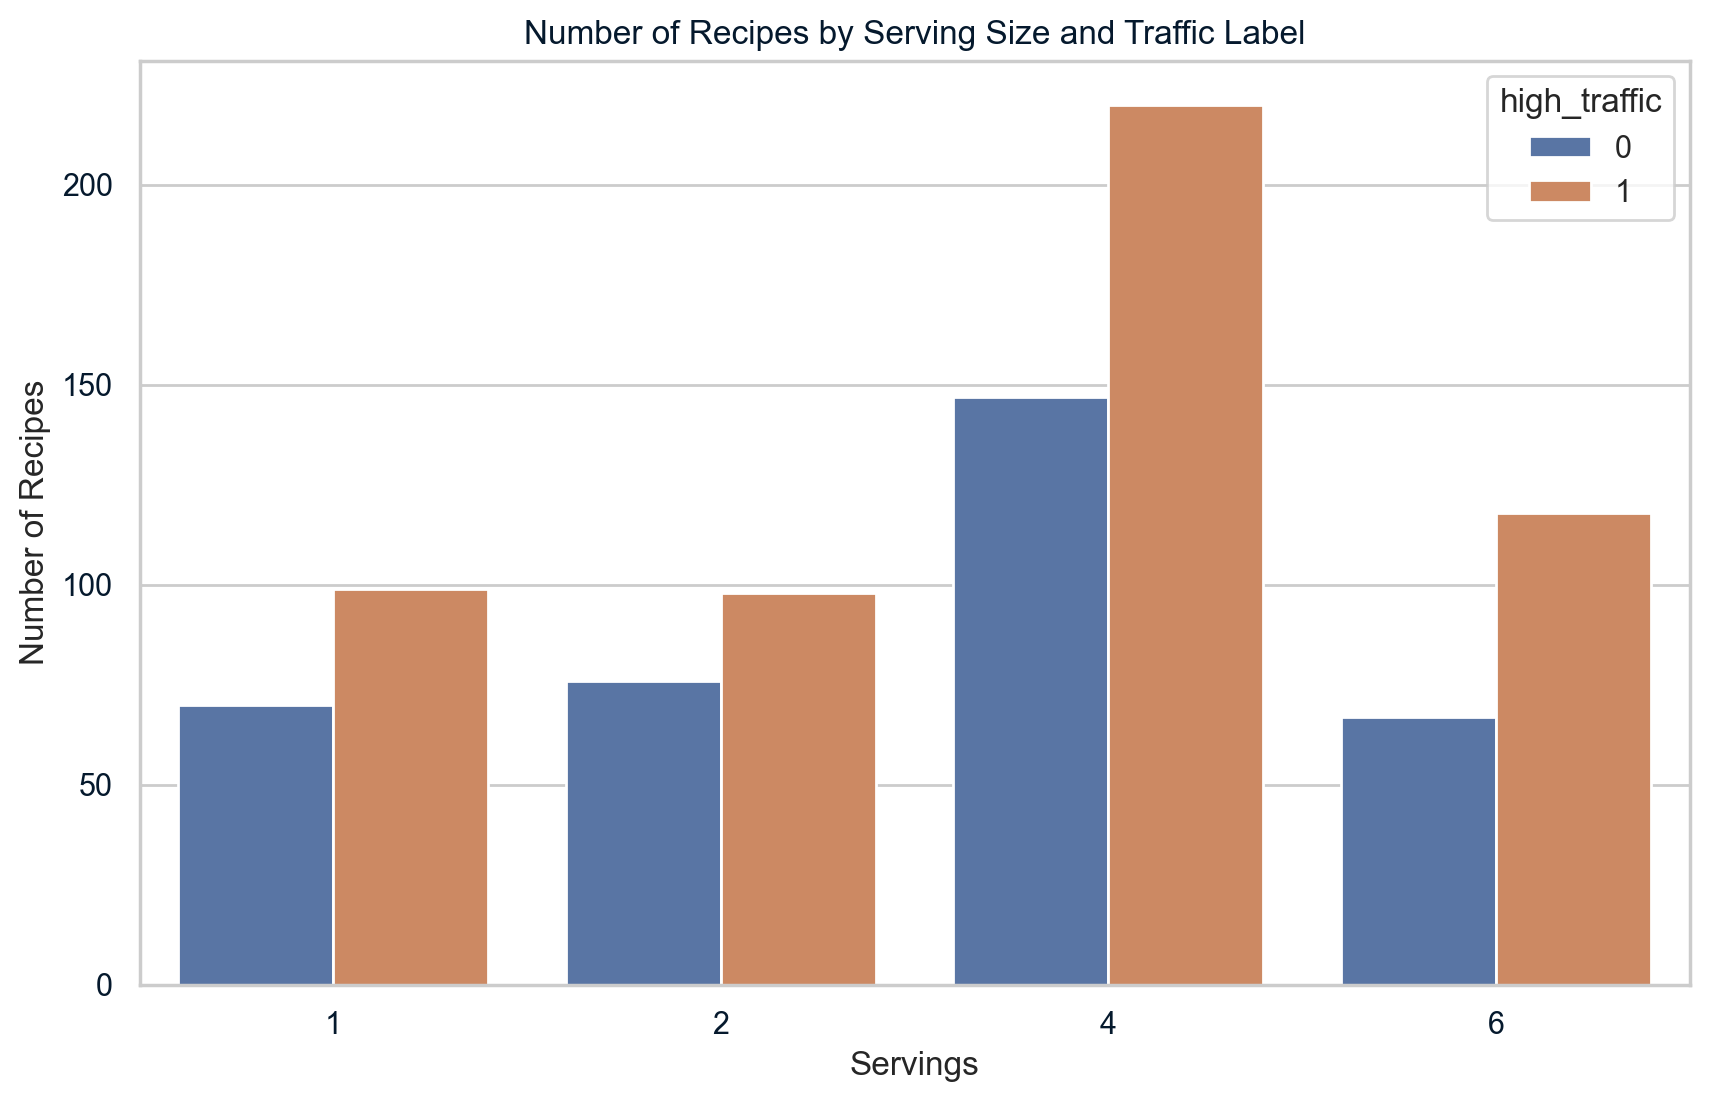

In [64]:
# Recipes by Serving Size and Traffic Label (High Traffic/Low Traffic)
# This bar plot shows the count of recipes for each serving size, split by high-traffic (1) and low-traffic (0) labels.
# Key Insight: Recipes with four servings tend to have the highest count overall, regardless of traffic label. 
# Although high-traffic recipes consistently outnumber low-traffic ones, no strong relationship between serving size and traffic is obvious.

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='servings', hue='high_traffic')
plt.title('Number of Recipes by Serving Size and Traffic Label')
plt.xlabel('Servings')
plt.ylabel('Number of Recipes')
plt.show()


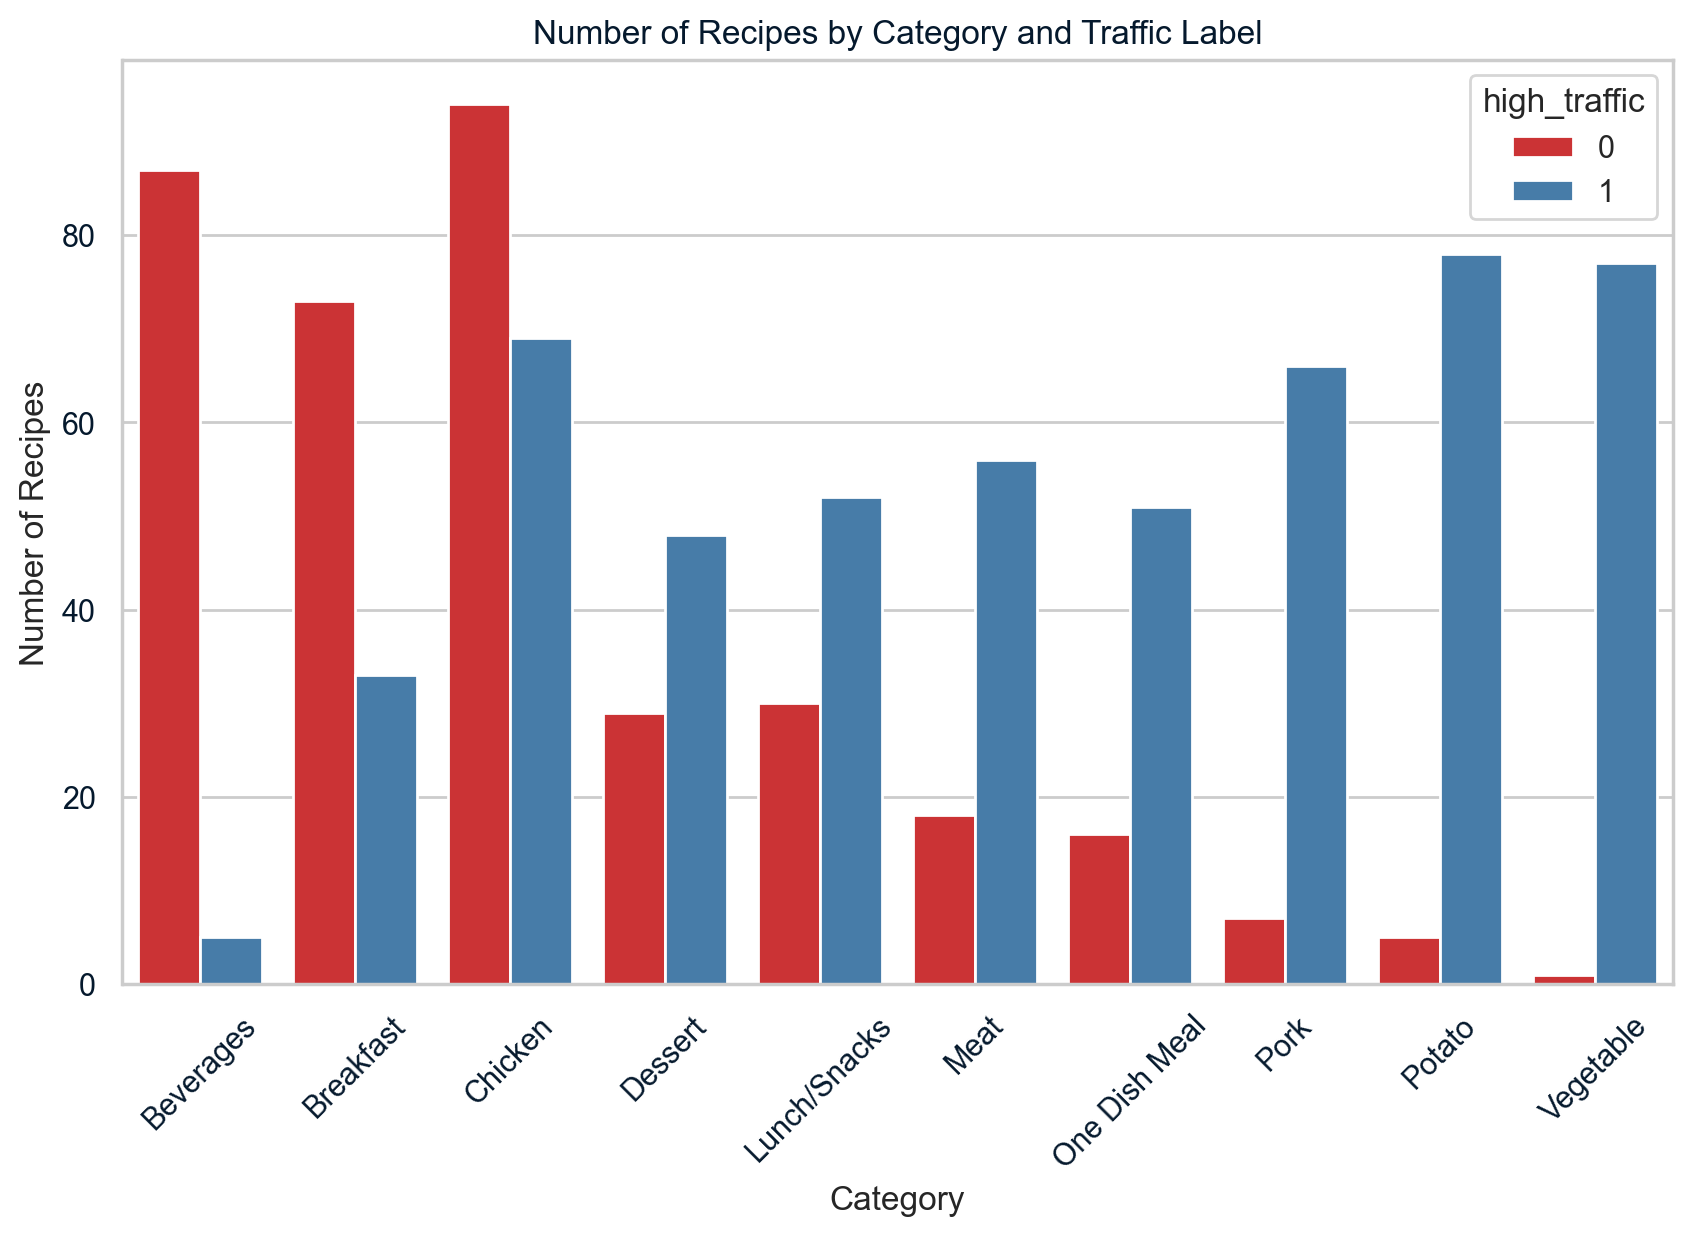

In [65]:
# Recipes by Category and Traffic Label (High Traffic/Low Traffic)
# This bar plot shows the count of recipes for each food category, again split by high-traffic (1) and low-traffic (0) labels.
# Key Insight: Categories like Chicken, Breakfast, and Beverages show relatively balanced traffic, while other categories (e.g., Potato, Vegetable, Pork) show a strong skew towards high-traffic recipes.
# This suggests that the 'category' feature may be an important predictor of high traffic.

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='category', hue='high_traffic', palette='Set1')
plt.title('Number of Recipes by Category and Traffic Label')
plt.xlabel('Category')
plt.ylabel('Number of Recipes')
plt.xticks(rotation=45)
plt.show()


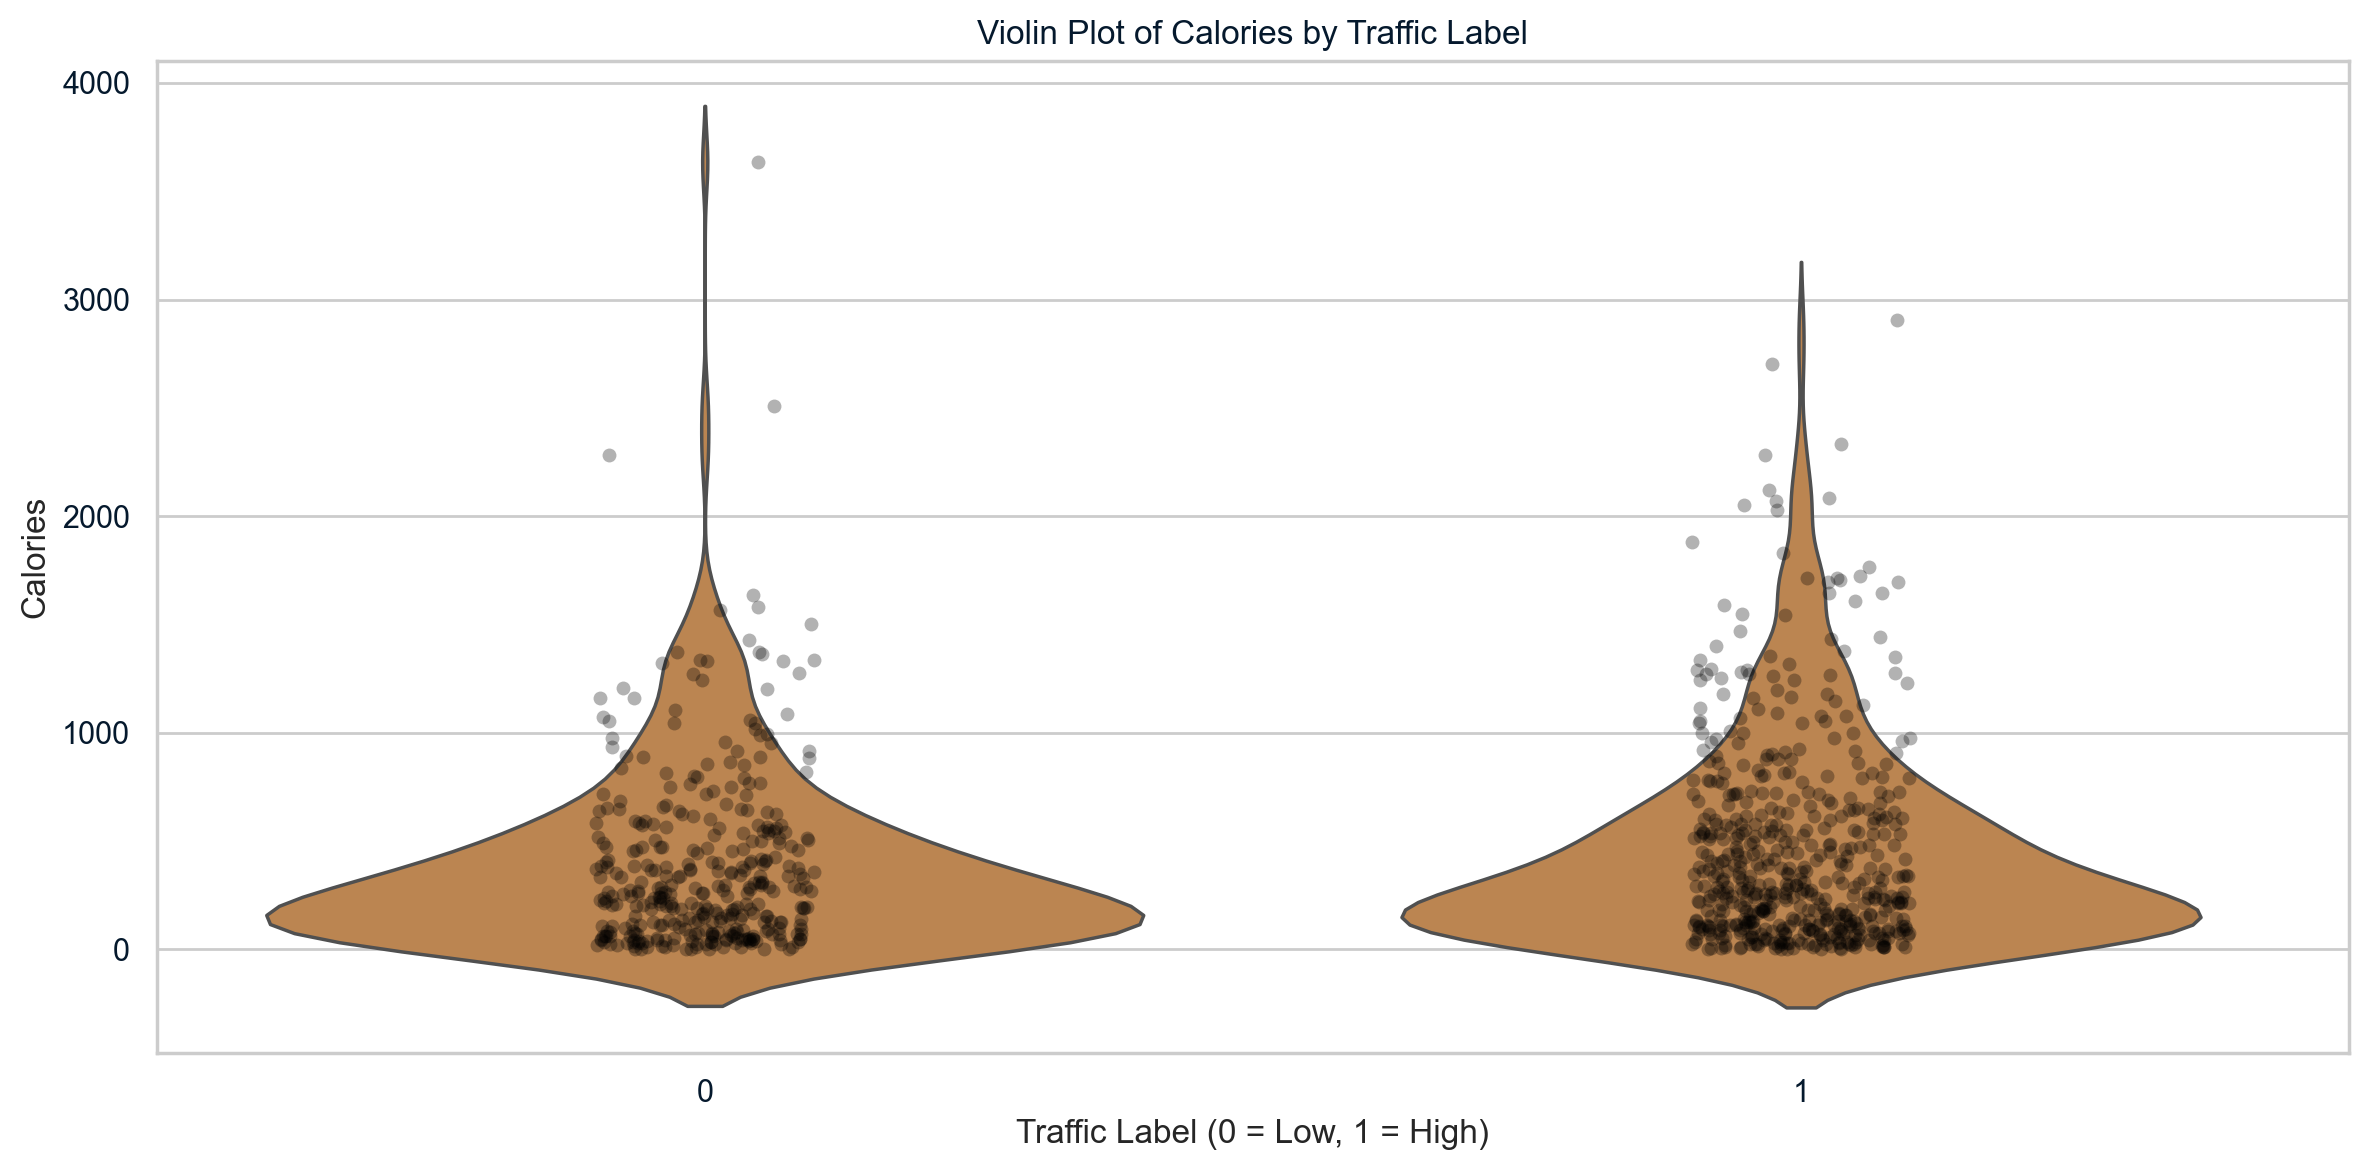

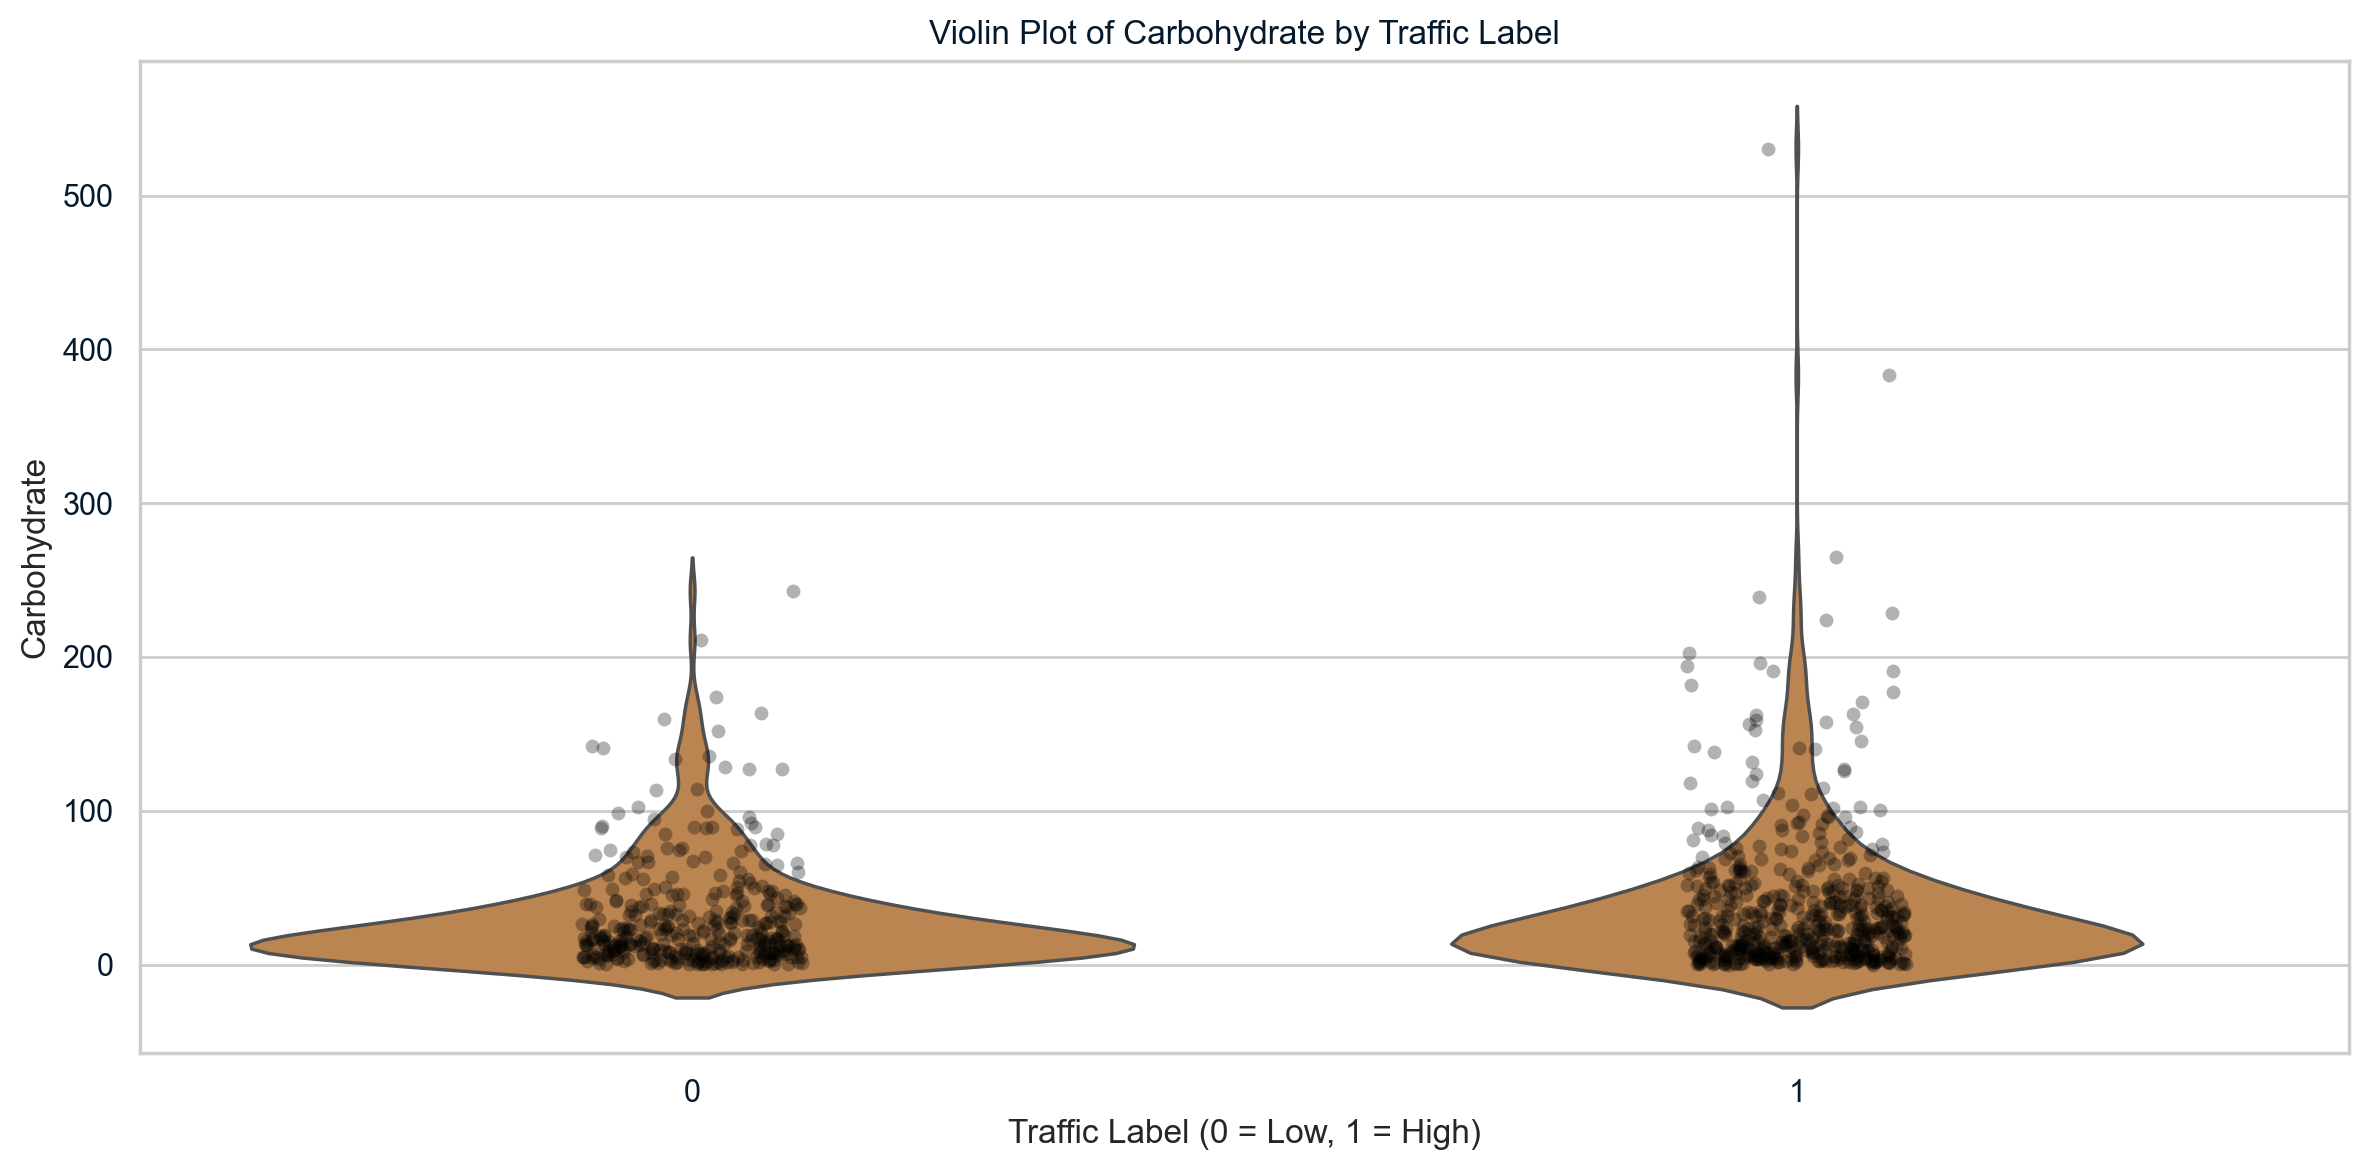

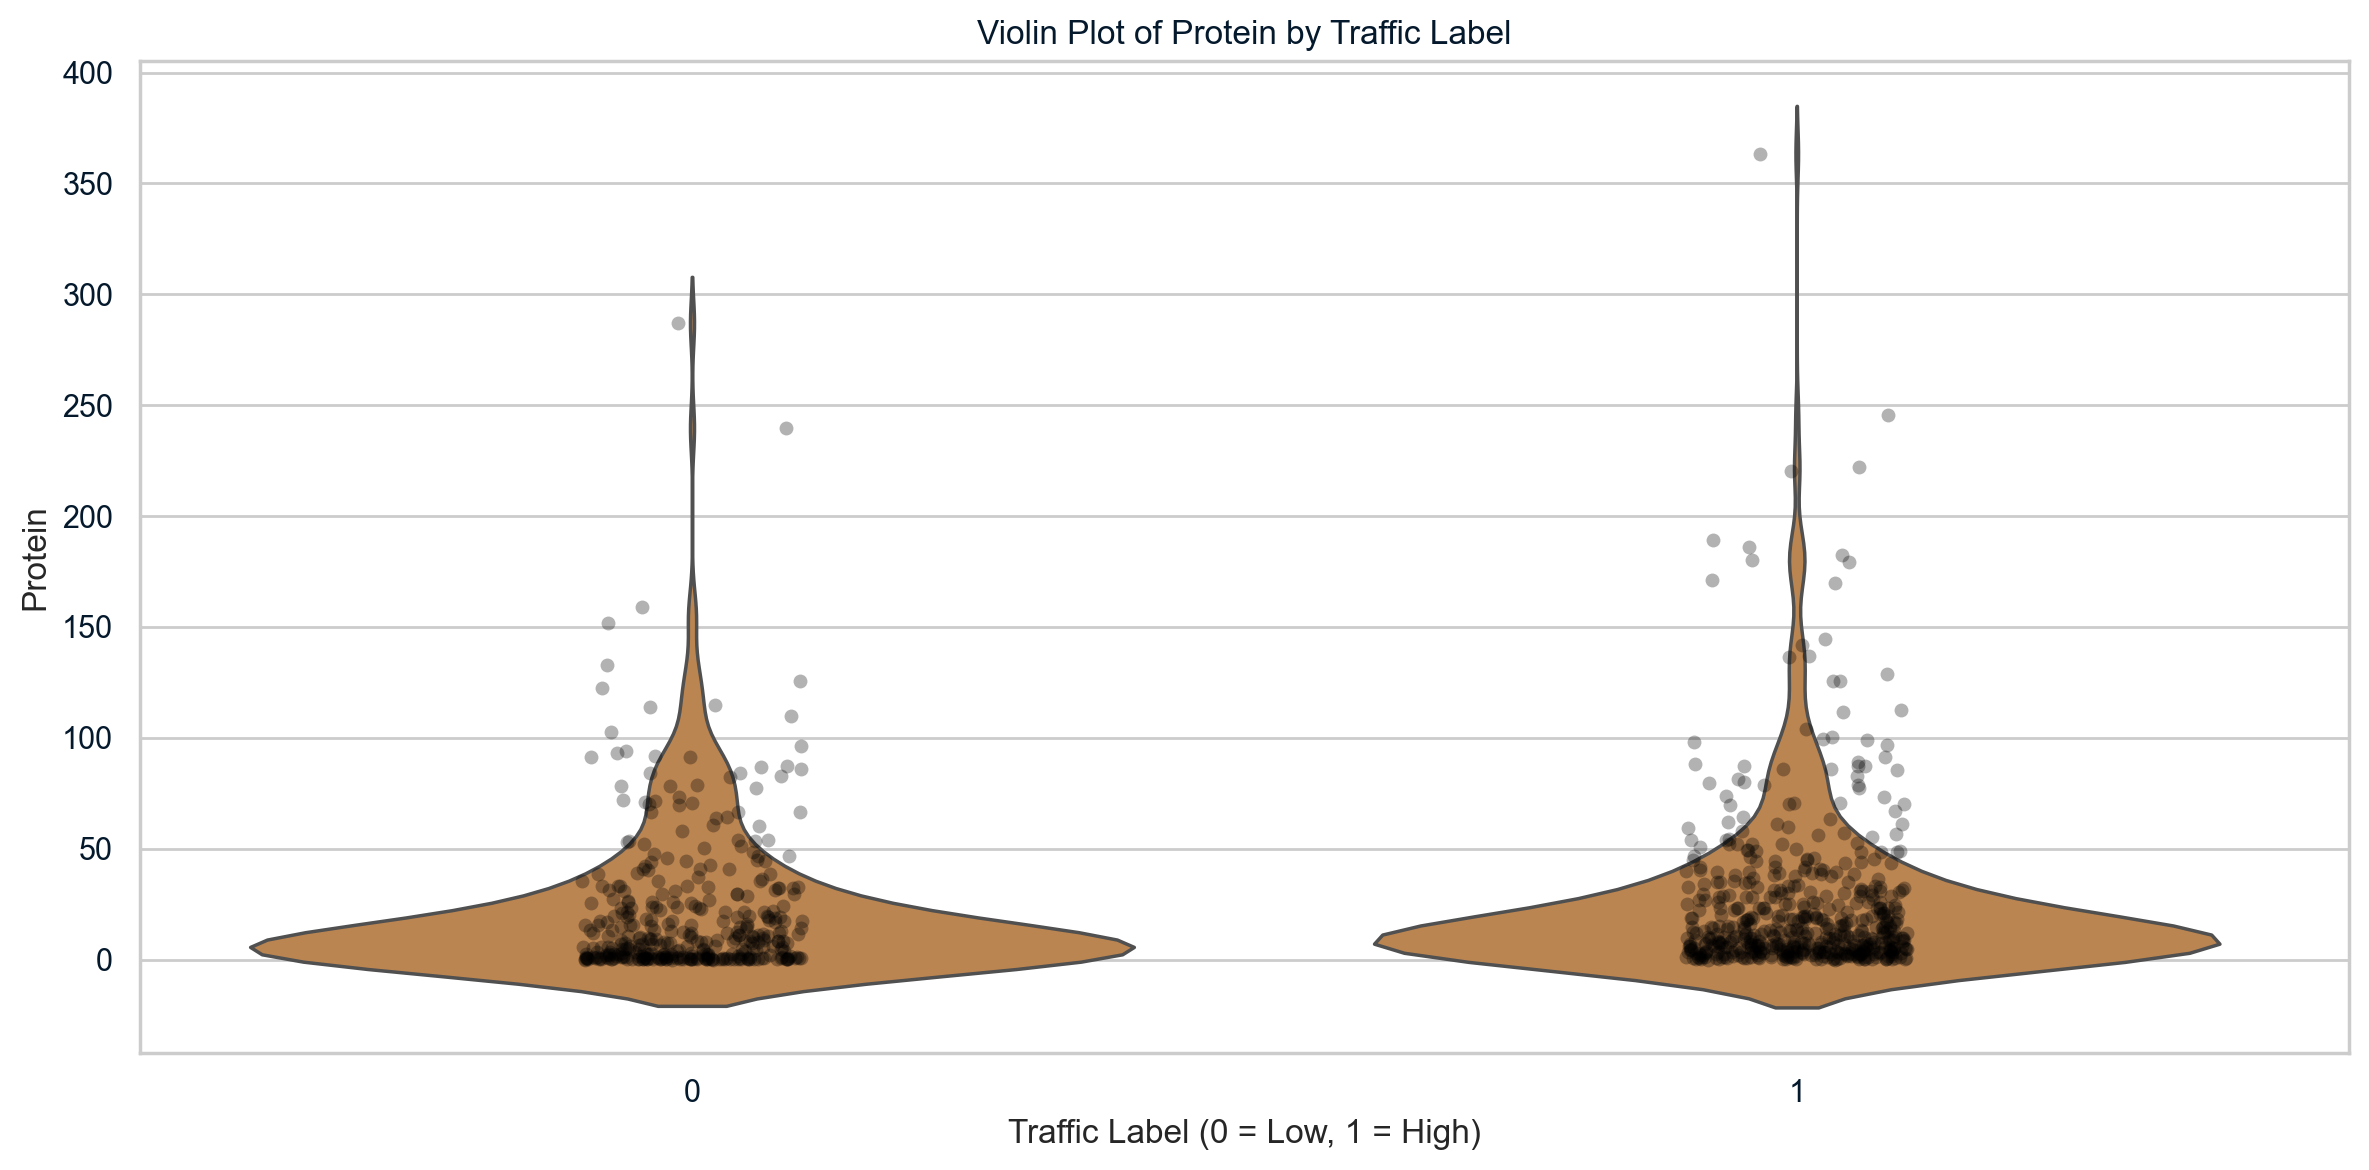

In [66]:
# 🔹 Violin Plots: Visualizing numeric features by traffic label
# Purpose: Explore how distributions of key numeric variables (calories, carbs, sugar, protein) differ between low-traffic (0) and high-traffic (1) recipes.
# Method: Combines violin plot for distribution shape and strip plot for raw data points.
# Key Stakeholder Insight:
# - Protein and Calories show more pronounced differences between low and high traffic, suggesting potential predictive power.
# - Sugar and Carbohydrates exhibit moderate overlap, indicating weaker differentiation between traffic levels.

for col in ['calories', 'carbohydrate', 'sugar', 'protein']:
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='high_traffic', y=col, data=df, inner=None, color='peru')
    sns.stripplot(x='high_traffic', y=col, data=df, color='black', alpha=0.3)
    plt.title(f'Violin Plot of {col.capitalize()} by Traffic Label')
    plt.xlabel('Traffic Label (0 = Low, 1 = High)')
    plt.ylabel(col.capitalize())
    plt.tight_layout()
    plt.show()


# 🔹 Boxen Plots (optional alternative)
# Purpose: Identify potential outliers and understand extreme value distribution by traffic label.
# Note: Currently commented out, but can be reactivated if needed for deeper analysis.
# Caution: Make sure the 'y' variable dynamically references 'col' instead of hardcoded 'protein'.

# for col in ['calories', 'carbohydrate', 'sugar', 'protein']:
#     plt.figure(figsize=(12, 6))
#     sns.boxenplot(x='high_traffic', y=col, data=df)
#     plt.title(f'Boxen Plot of {col.capitalize()} by Traffic Label')
#     plt.xlabel('Traffic Label (0 = Low, 1 = High)')
#     plt.ylabel(col.capitalize())
#     plt.tight_layout()
#     plt.show()



### Violin Plots for [calories, sugar, protein, carbohydrate] vs. Traffic Label

- Audience: Both
- Insight:
    1. Protein and calories distributions differ more for high-traffic vs. low-traffic.
    2. Sugar and carbohydrates show moderate overlap.

In [67]:
# 🔹 Pairplot: Visualizing Relationships Between Nutritional Features and Traffic Label
# Purpose:
# - Explore pairwise relationships between key nutritional variables (calories, carbohydrate, sugar, protein).
# - Identify potential linear or non-linear patterns that differentiate high-traffic (1) and low-traffic (0) recipes.
# - Use KDE on the diagonal for density estimation to detect skewness or clustering.
# Insights:
# - Weak linear correlations observed; scatter suggests possible non-linear interactions.
# - Non-linearities imply that tree-based models (e.g. Random Forest, XGBoost) might capture complex patterns better than linear models.
# - Density plots reveal that calories and protein distributions differ between high and low traffic, hinting at potential predictive features.

sns.pairplot(
    df[['calories', 'carbohydrate', 'sugar', 'protein', 'high_traffic']],
    hue='high_traffic',
    diag_kind='kde',
    palette='Set2'
)
plt.suptitle('Pairplot of Nutritional Features by Traffic Label', y=1.02)
plt.show()


In [68]:
# 🔹 Correlation Heatmap of Nutritional Features
# Purpose:
# - Visualize linear relationships between key nutritional variables (calories, carbohydrate, sugar, protein).
# - Identify potential multicollinearity issues that could affect model stability.
# Insights:
# - All feature pairs have weak correlations (|r| < 0.2), indicating no multicollinearity concerns.
# - These features likely provide independent signals, supporting their inclusion in modeling.
# - Highlights opportunity to explore complex interactions using non-linear models.

plt.figure(figsize=(8, 6))
sns.heatmap(df[['calories', 'carbohydrate', 'sugar', 'protein']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Nutritional Features")
plt.tight_layout()
plt.show()


#### Heatmap of Nutritional Correlations
- A udience: Head of DS
- Insight: All feature pairs show very weak linear correlations (less than 0.2).
- This indicates no risk of multicollinearity, so each feature can contribute distinct information to the model.
- Suggests focusing on non-linear modeling or feature interactions (e.g., tree models) to fully capture relationships.

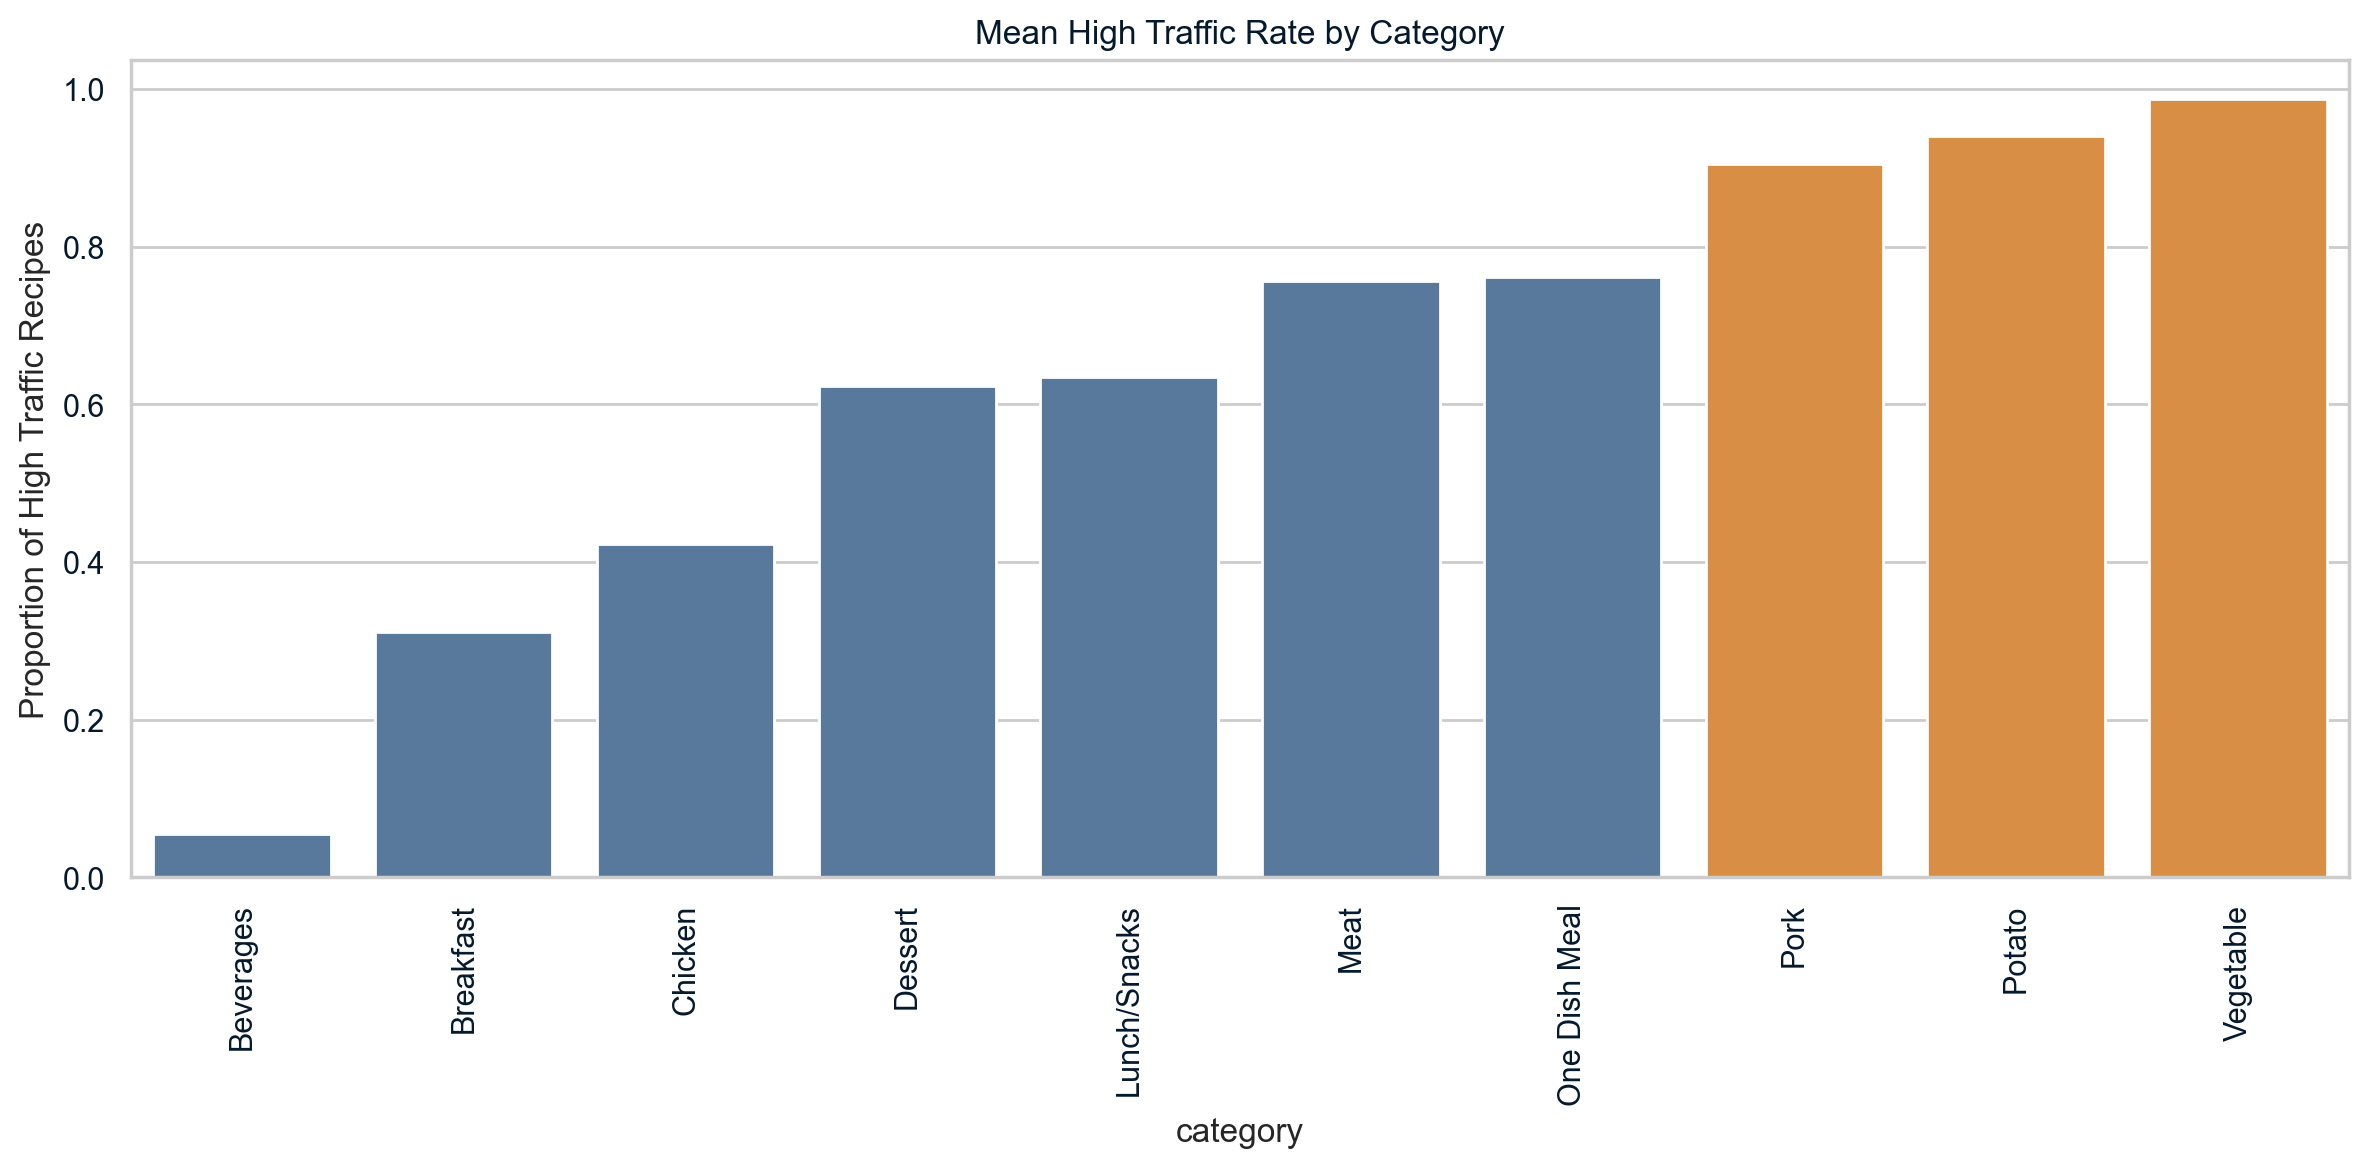

In [69]:
# 🔹 Bar Plot: Mean High-Traffic Rate by Category (Category vs. Mean High Traffic)
# Purpose:
# - Identify categories with higher average traffic, guiding marketing or content focus.
# - Color-code highlights (orange for high-traffic categories).
# Insights:
# - 'Vegetable', 'Potato', and 'Pork' categories consistently attract higher-than-average traffic.
# - Business can prioritize recipes in these categories for targeted promotions or content creation.
# - Servings might have limited predictive power; focus on content strategy around high-traffic categories.

traffic_by_cat = df.groupby('category')['high_traffic'].mean().sort_values()
plt.figure(figsize=(12, 6))
colors = ['#f28e2c' if val > 0.8 else '#4e79a7' for val in traffic_by_cat.values]
sns.barplot(x=traffic_by_cat.index, y=traffic_by_cat.values, palette=colors)
plt.xticks(rotation=90)
plt.ylabel('Proportion of High Traffic Recipes')
plt.title('Mean High Traffic Rate by Category')
plt.tight_layout()
plt.show()


#### Bar Plot: Mean High-Traffic Rate by Category

Audience: Product Manager

Insights:

- Top Performers: ‘Vegetable’, ‘Potato’, and ‘Pork’ categories have the highest average high-traffic rates, suggesting these are priority areas for marketing and content strategy.

- Visual Cues: Orange bars highlight categories with >80% high-traffic rates, signaling strong engagement potential.

- Actionable Recommendation: Focus marketing campaigns, featured content, or recipe highlights around these top categories to drive traffic.

### Additional EDA Visualizations

To better understand the feature-target relationships, we included violin plots, category-level bar charts, and a correlation heatmap. Key takeaways:

- **Violin Plots** Reveal overlapping distributions for calories and sugar, while protein shows more separation. ➤ Suggests protein might be a useful feature in modeling.
- **Pairplots** Confirm weak linear correlations but hint at possible non-linear interactions (good case for tree-based models).
- **Category Bar Plot** Highlights ‘Pork’, ‘Vegetable’, and ‘Potato’ as high-traffic magnets—great for product strategy.
- **Servings** do not show a clear trend and might be a weak predictor.


In [70]:
# =====================
# SECTION 7: Outlier Detection Recap & Modeling Decision
# =====================

# Step 1: Recalculate Z-scores grouped by category
z_scores = df.groupby('category')[['calories', 'carbohydrate', 'sugar', 'protein']]\
             .transform(lambda x: np.abs(zscore(x)))

outliers = (z_scores > 3).any(axis=1)
total_outliers = outliers.sum()
outlier_pct = total_outliers / len(df) * 100

print(f"Outliers Detected: {total_outliers} ({outlier_pct:.2f}% of dataset)")

# ✅ Modeling Decision:
# • We are NOT removing outliers from the dataset before modeling.
# • Detected outliers (~8%) reflect valid, extreme recipes (e.g., high-calorie meat dishes).
# • Removing them would risk underfitting and data bias.
# • Tree-based classifiers (Random Forest, XGBoost) can handle them well.
# • Final dataset preserves full variability and signal for better generalization.


Outliers Detected: 73 (8.16% of dataset)


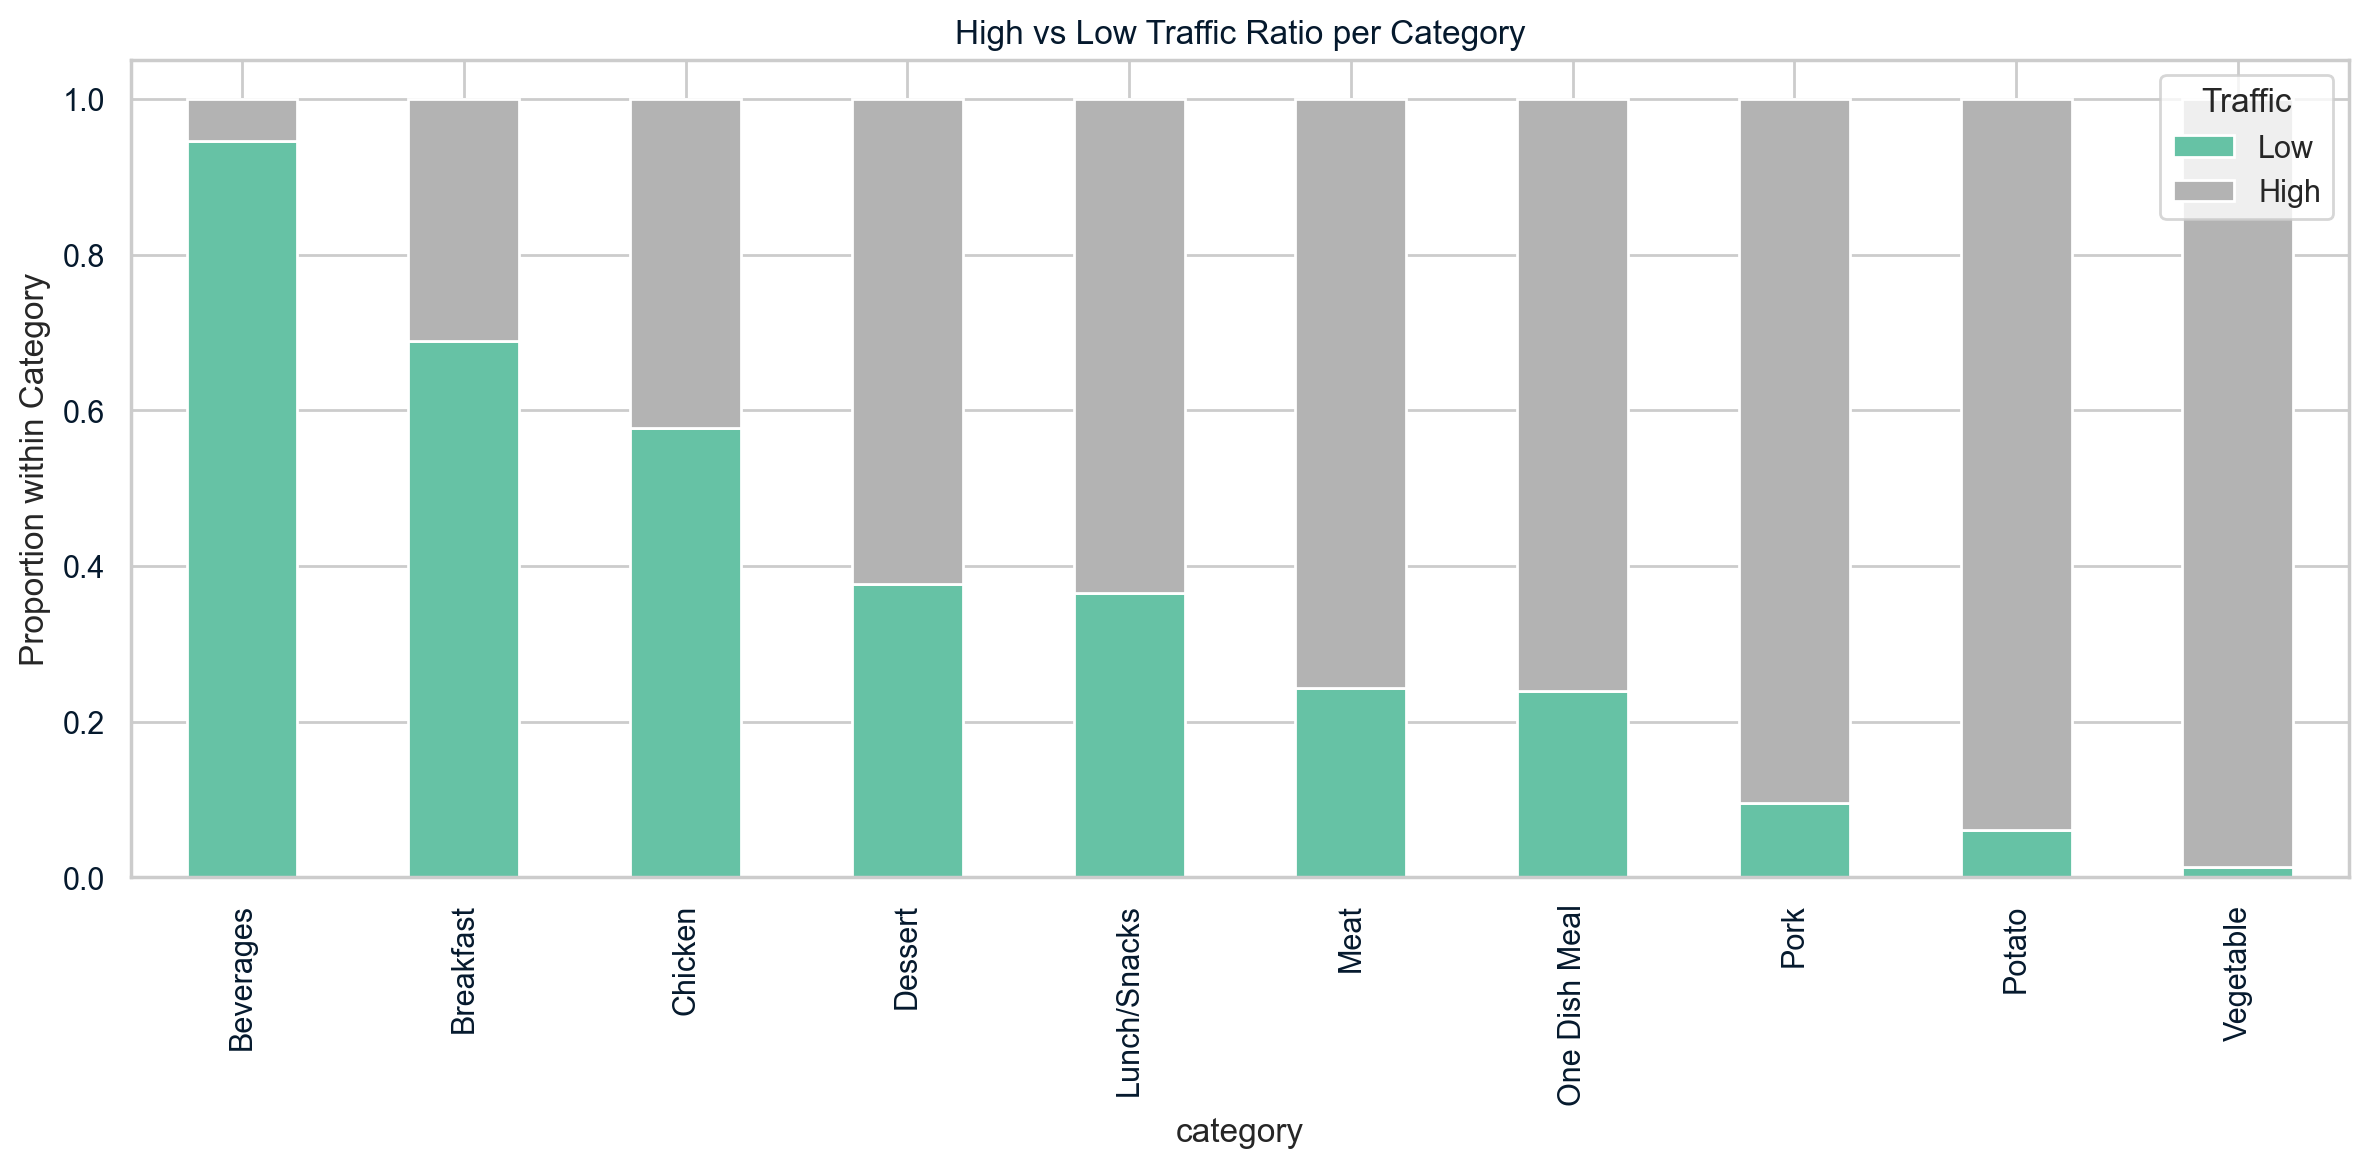

In [71]:
# Stacked Bar Plot for Category + Traffic
# Purpose:
# - Visualize how traffic (high vs. low) breaks down within each category.
# - Helps identify categories where high-traffic recipes dominate (or lag).
# Business Impact:
# - Pinpoints key content categories for marketing prioritization or homepage curation.

cat_traffic = pd.crosstab(df['category'], df['high_traffic'], normalize='index')
cat_traffic.plot(kind='bar', stacked=True, colormap='Set2', figsize=(12,6))
plt.title("High vs Low Traffic Ratio per Category")
plt.ylabel("Proportion within Category")
plt.legend(["Low", "High"], title="Traffic")
plt.tight_layout()
plt.show()


Audience: Product Manager

- Top Performers: 'Vegetable', 'Potato', and 'Pork' categories dominate with a higher proportion of high-traffic recipes.

- Underperformers: 'Beverages' and 'Breakfast' have relatively low high-traffic proportions, signaling less organic interest.

- Actionable Recommendations: Prioritize content curation and promotional focus on the high-performing categories to maximize recipe traffic and engagement.


In [72]:
# # Protein Distribution by Category
# plt.figure(figsize=(12,6))
# sns.boxplot(x='category', y='protein', data=df)
# plt.xticks(rotation=90)
# plt.title("Protein Levels by Category")
# plt.tight_layout()
# plt.show()


Reveals the range, central tendency, and outliers of protein content across categories.
Makes it obvious which categories (like Chicken and Meat) are higher-protein and more variable.

Audience: Head of Data Science, Nutrition/Content Strategist

Insight: Protein levels vary significantly by category. Chicken, Meat, and Pork show a wider range and higher median protein content, which might influence engagement.

➤ Given earlier findings that higher protein often correlates with high traffic, these categories could be prioritized for testing high-protein recipe promotion.

In [73]:
# # Calories Distribution by Category

# plt.figure(figsize=(10,6))
# sns.boxplot(x='category', y='calories', data=df)
# plt.title('Calories by Category')
# plt.xlabel('Category')
# plt.ylabel('Calories')
# plt.xticks(rotation=45)
# plt.show()

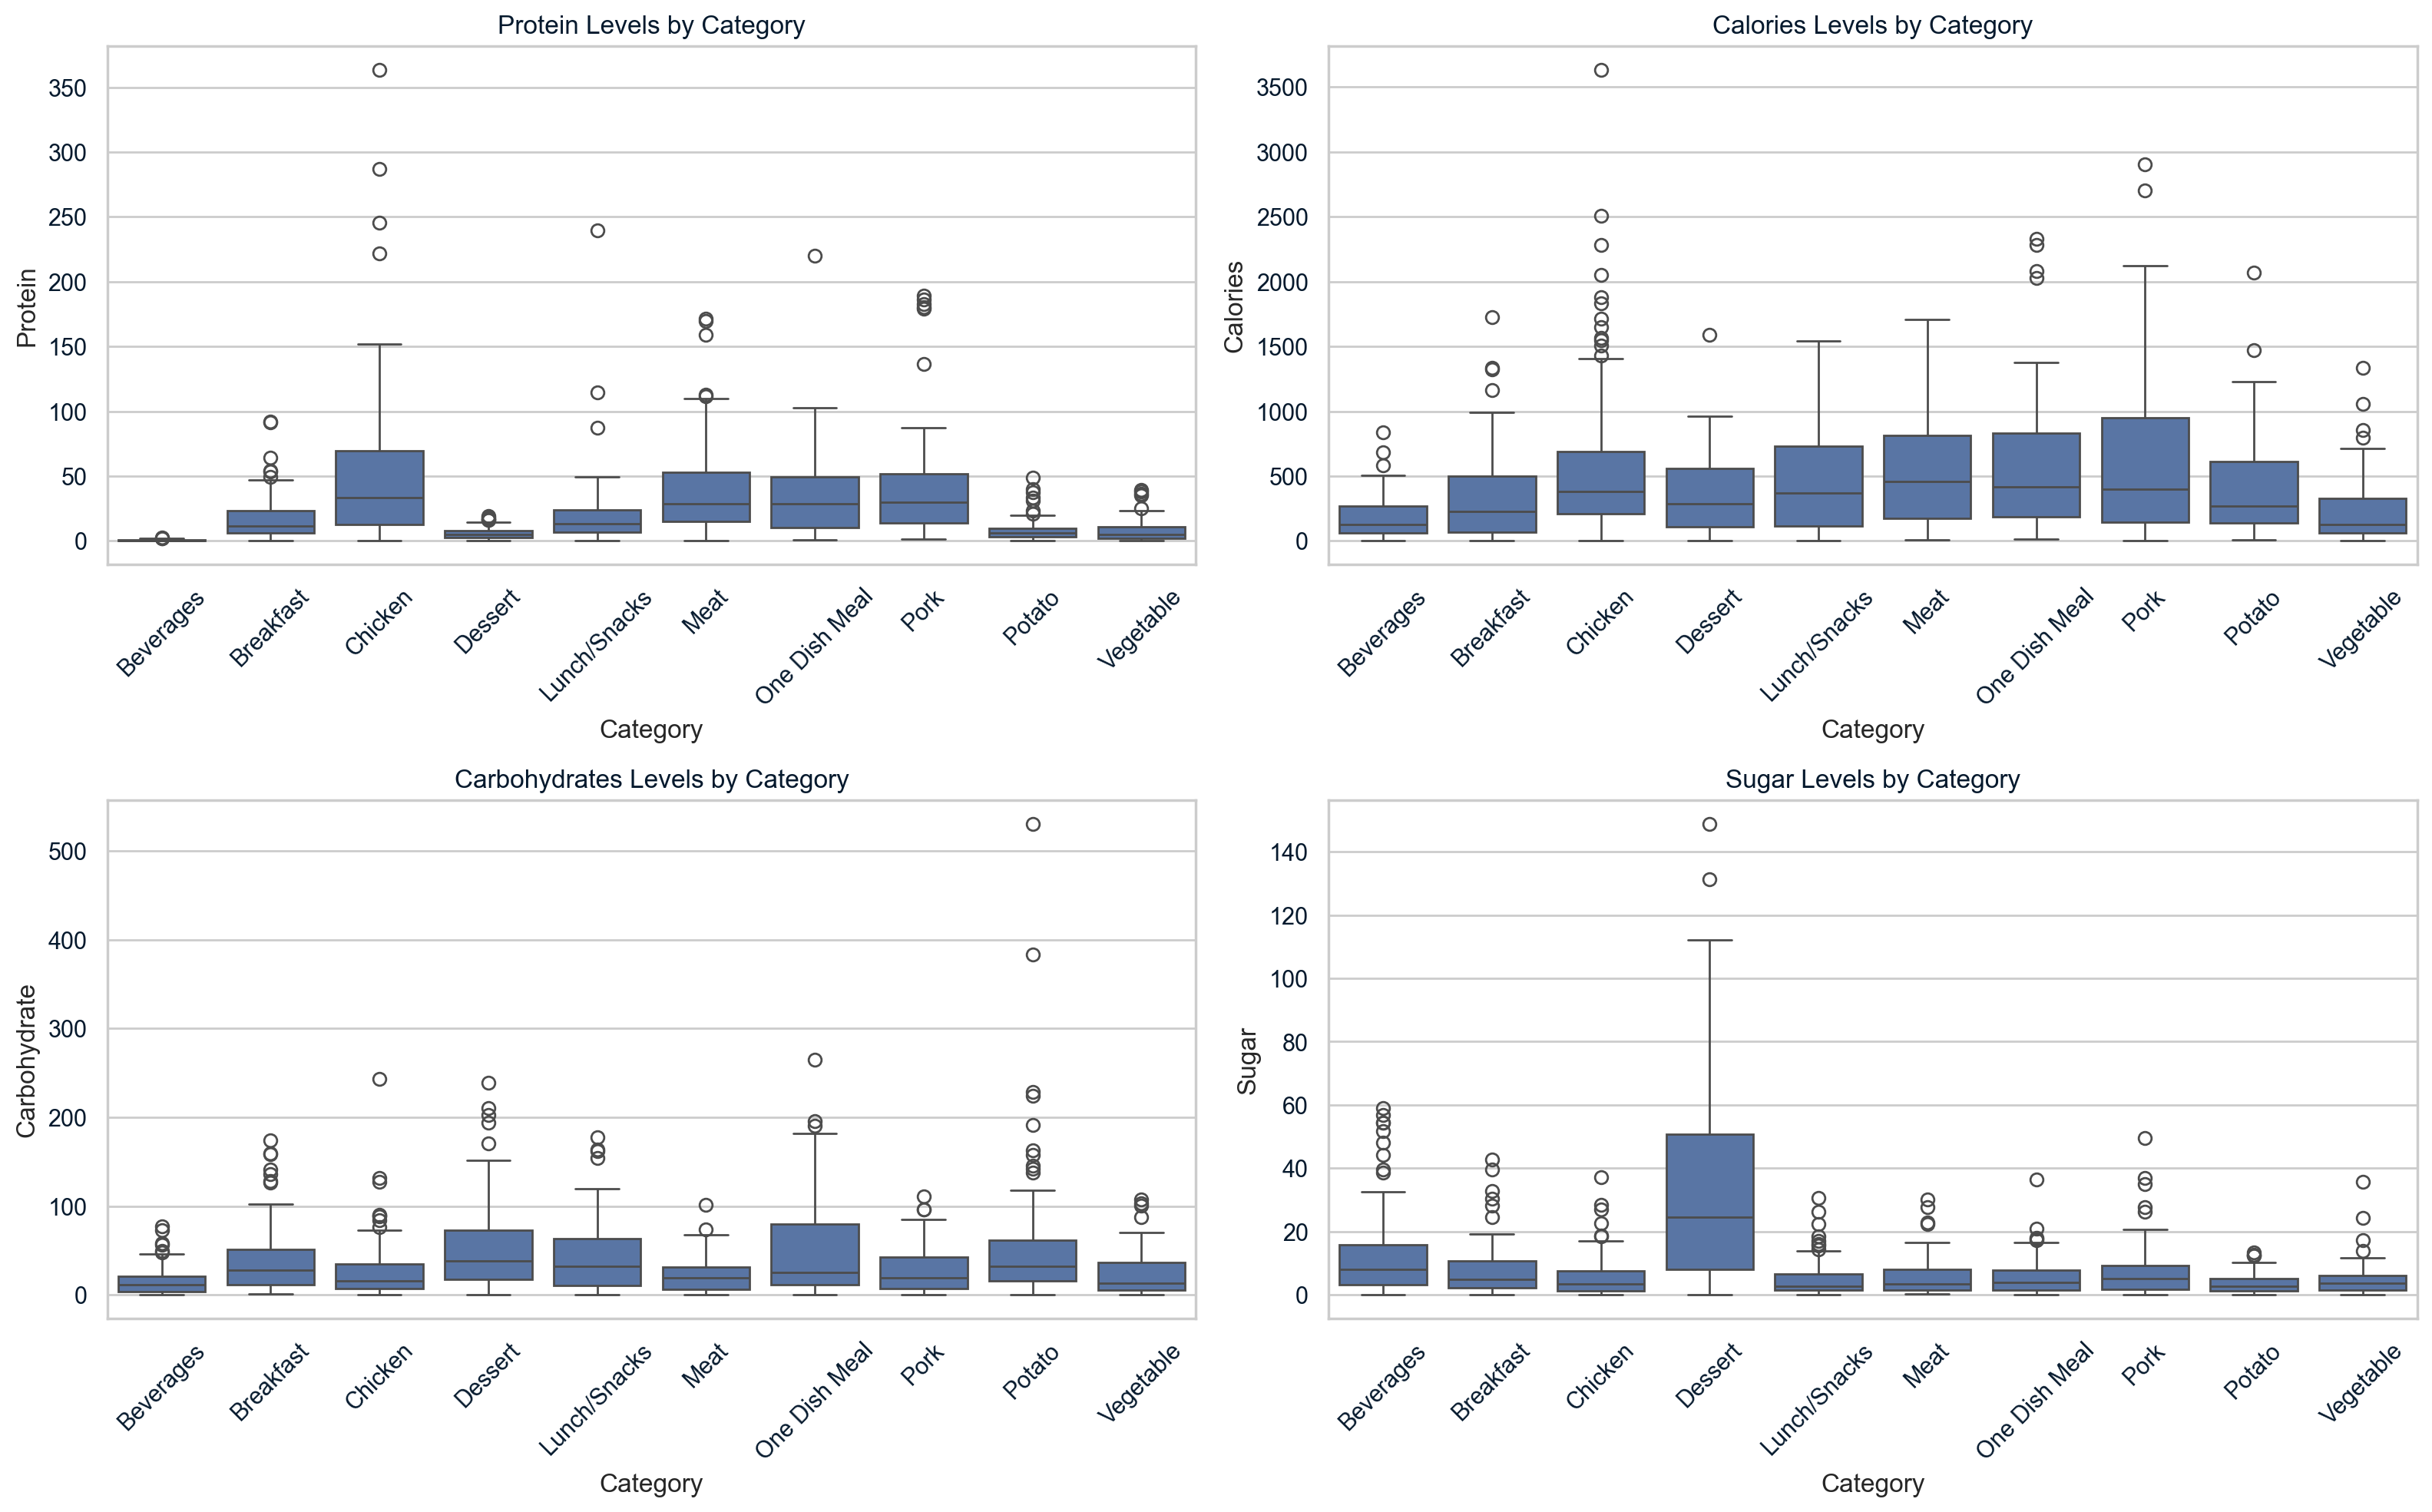

In [74]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

nutritional_vars = ['protein', 'calories', 'carbohydrate', 'sugar']
titles = ['Protein Levels by Category', 
          'Calories Levels by Category', 
          'Carbohydrates Levels by Category', 
          'Sugar Levels by Category']

for ax, var, title in zip(axs.flatten(), nutritional_vars, titles):
    sns.boxplot(x='category', y=var, data=df, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Category')
    ax.set_ylabel(var.capitalize())
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Audience: Head of Data Science, Nutrition/Content Strategist, and Product Manager

Purpose:
This combined boxplot visualization helps us understand distribution patterns and variability of key nutritional features (protein, calories, carbs, sugar) across recipe categories.

Key Insights:

Protein: Chicken, Meat, and Pork categories have significantly higher median protein levels and wider spreads — aligning with earlier findings that high-protein recipes attract more traffic.

Calories: Calorie levels are relatively consistent across categories but exhibit high variability — with spikes especially in Chicken, One Dish Meal, and Pork. This may influence portion recommendations or dietary labeling.

Carbohydrates: Notable variability across categories like Potato and Dessert; suggests potential to highlight lower-carb recipes for health-conscious users.

Sugar: Dessert stands out with the highest sugar variability — useful for flagging potential “sugar bomb” recipes to attract or caution users.

### Model Development ###

Problem Type:
This is a binary classification problem – predicting whether a recipe will result in high traffic (1) or not (0), based on nutritional features and recipe category.

In [75]:
# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, roc_curve, classification_report,
    confusion_matrix, precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 2. LOAD CLEANED DATA
df = pd.read_csv("cleaned_recipe_site_traffic.csv")

# Filter out rows where target variable is missing (should already be handled but double-check)
df = df[df['high_traffic'].notnull()]
df['high_traffic'] = df['high_traffic'].astype(int)

# Feature Engineering: Create ratio features and interaction terms
# These help the model learn richer patterns
df['protein_per_calorie'] = df['protein'] / (df['calories'] + 1)
df['sugar_to_carbs'] = df['sugar'] / (df['carbohydrate'] + 1)
df['protein_x_servings'] = df['protein'] * df['servings']

# 3. SELECT FEATURES & TARGET
features = [
    'calories', 'carbohydrate', 'sugar', 'protein', 'servings',
    'protein_per_calorie', 'sugar_to_carbs', 'protein_x_servings', 'category'
]
target = 'high_traffic'
numeric_features = [f for f in features if f != 'category']  # Numerical features
categorical_features = ['category']  # One-hot encoded

# Train/Test Split with stratification to preserve class distribution
X = df[features]
y = df[target]
# Stratified split to keep class distribution balanced in train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

# 4. PREPROCESSING PIPELINE
# Apply median imputation, log transform to reduce skewness, then min-max scaling to standardize features
log_minmax_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(np.log1p, validate=False)),
    ('scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer([
    ('num', log_minmax_pipeline, numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# 5. DEFINE MODELS
# Models selected to compare linear and non-linear classifiers
models = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced', max_iter=500, random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        class_weight='balanced', n_estimators=50, max_depth=5, random_state=42
    ),
    'XGBoost': XGBClassifier(
        eval_metric='logloss', use_label_encoder=False, n_estimators=50,
        max_depth=3, learning_rate=0.05,
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
        random_state=42
    )
}

# 6. TRAIN & FIT MODELS
# Fit each model using a pipeline that includes preprocessing and the classifier
fitted_models = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('clf', model)
    ])
    pipeline.fit(X_train, y_train)
    fitted_models[name] = pipeline


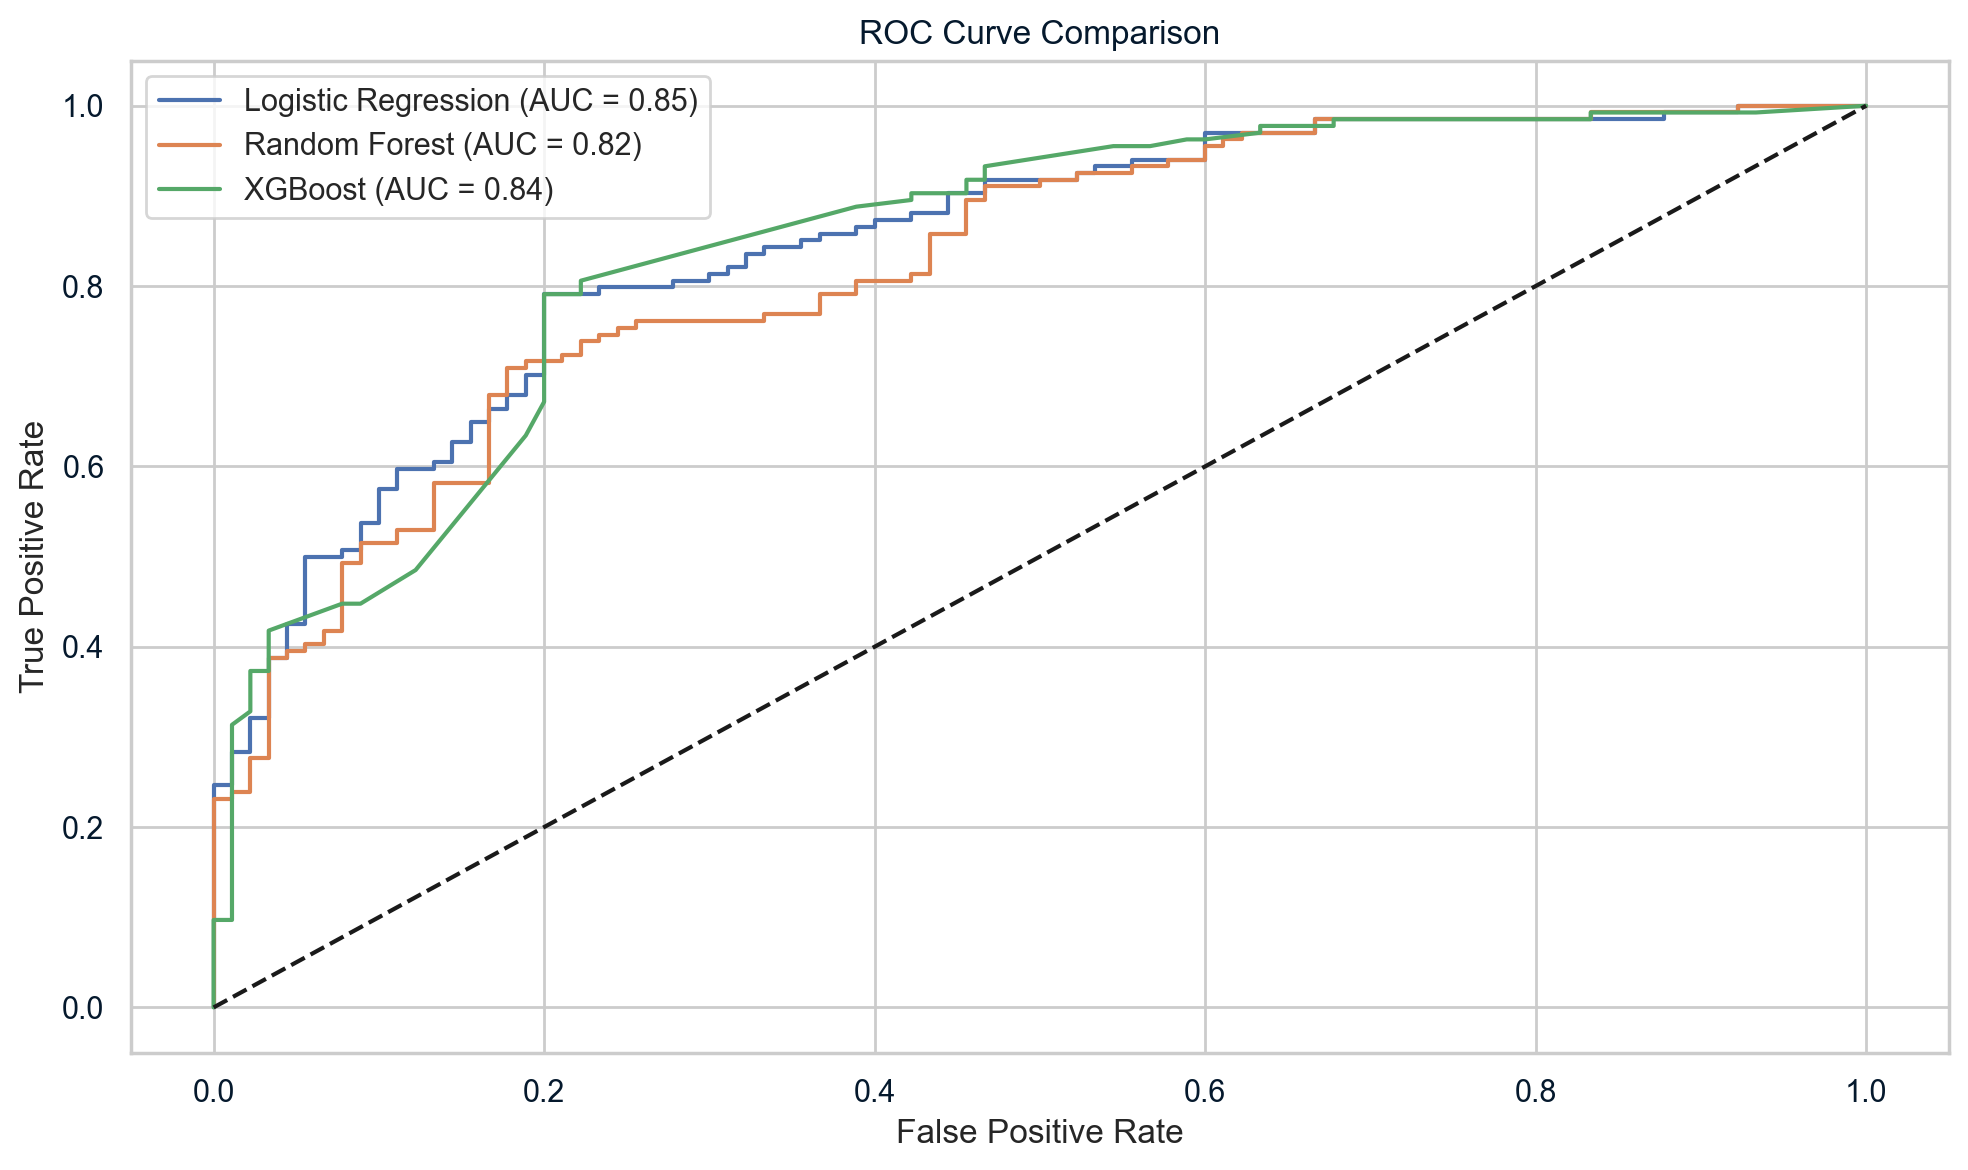


Logistic Regression Confusion Matrix:
[[82  8]
 [62 72]]
              precision    recall  f1-score   support

           0       0.57      0.91      0.70        90
           1       0.90      0.54      0.67       134

    accuracy                           0.69       224
   macro avg       0.73      0.72      0.69       224
weighted avg       0.77      0.69      0.68       224

Precision Score: 0.90
Accuracy Score: 0.69

Random Forest Confusion Matrix:
[[74 16]
 [42 92]]
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        90
           1       0.85      0.69      0.76       134

    accuracy                           0.74       224
   macro avg       0.74      0.75      0.74       224
weighted avg       0.77      0.74      0.74       224

Precision Score: 0.85
Accuracy Score: 0.74

XGBoost Confusion Matrix:
[[72 18]
 [39 95]]
              precision    recall  f1-score   support

           0       0.65      0.80      0.72      

In [76]:
# ================================
# MODEL EVALUATION
# ================================

from sklearn.metrics import precision_score, accuracy_score

# ROC CURVES
# 🔹 Visualizes model performance in terms of AUC.
# 🔹 Higher AUC = better ability to distinguish high vs low traffic recipes.
plt.figure(figsize=(10, 6))
for name, model in fitted_models.items():
    X_trans = model.named_steps['preprocess'].transform(X_test)
    y_proba = model.named_steps['clf'].predict_proba(X_trans)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrices & Classification Report
# 🔹 Evaluate model performance at a custom threshold (0.52) that balances precision and recall.
# 🔹 Shows trade-offs between true positives, false positives, etc.
threshold = 0.52  # Based on balancing precision and recall
for name, model in fitted_models.items():
    X_trans = model.named_steps['preprocess'].transform(X_test)
    y_proba = model.named_steps['clf'].predict_proba(X_trans)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    
    print(f"\n{name} Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Precision Score: {precision:.2f}")
    print(f"Accuracy Score: {accuracy:.2f}")


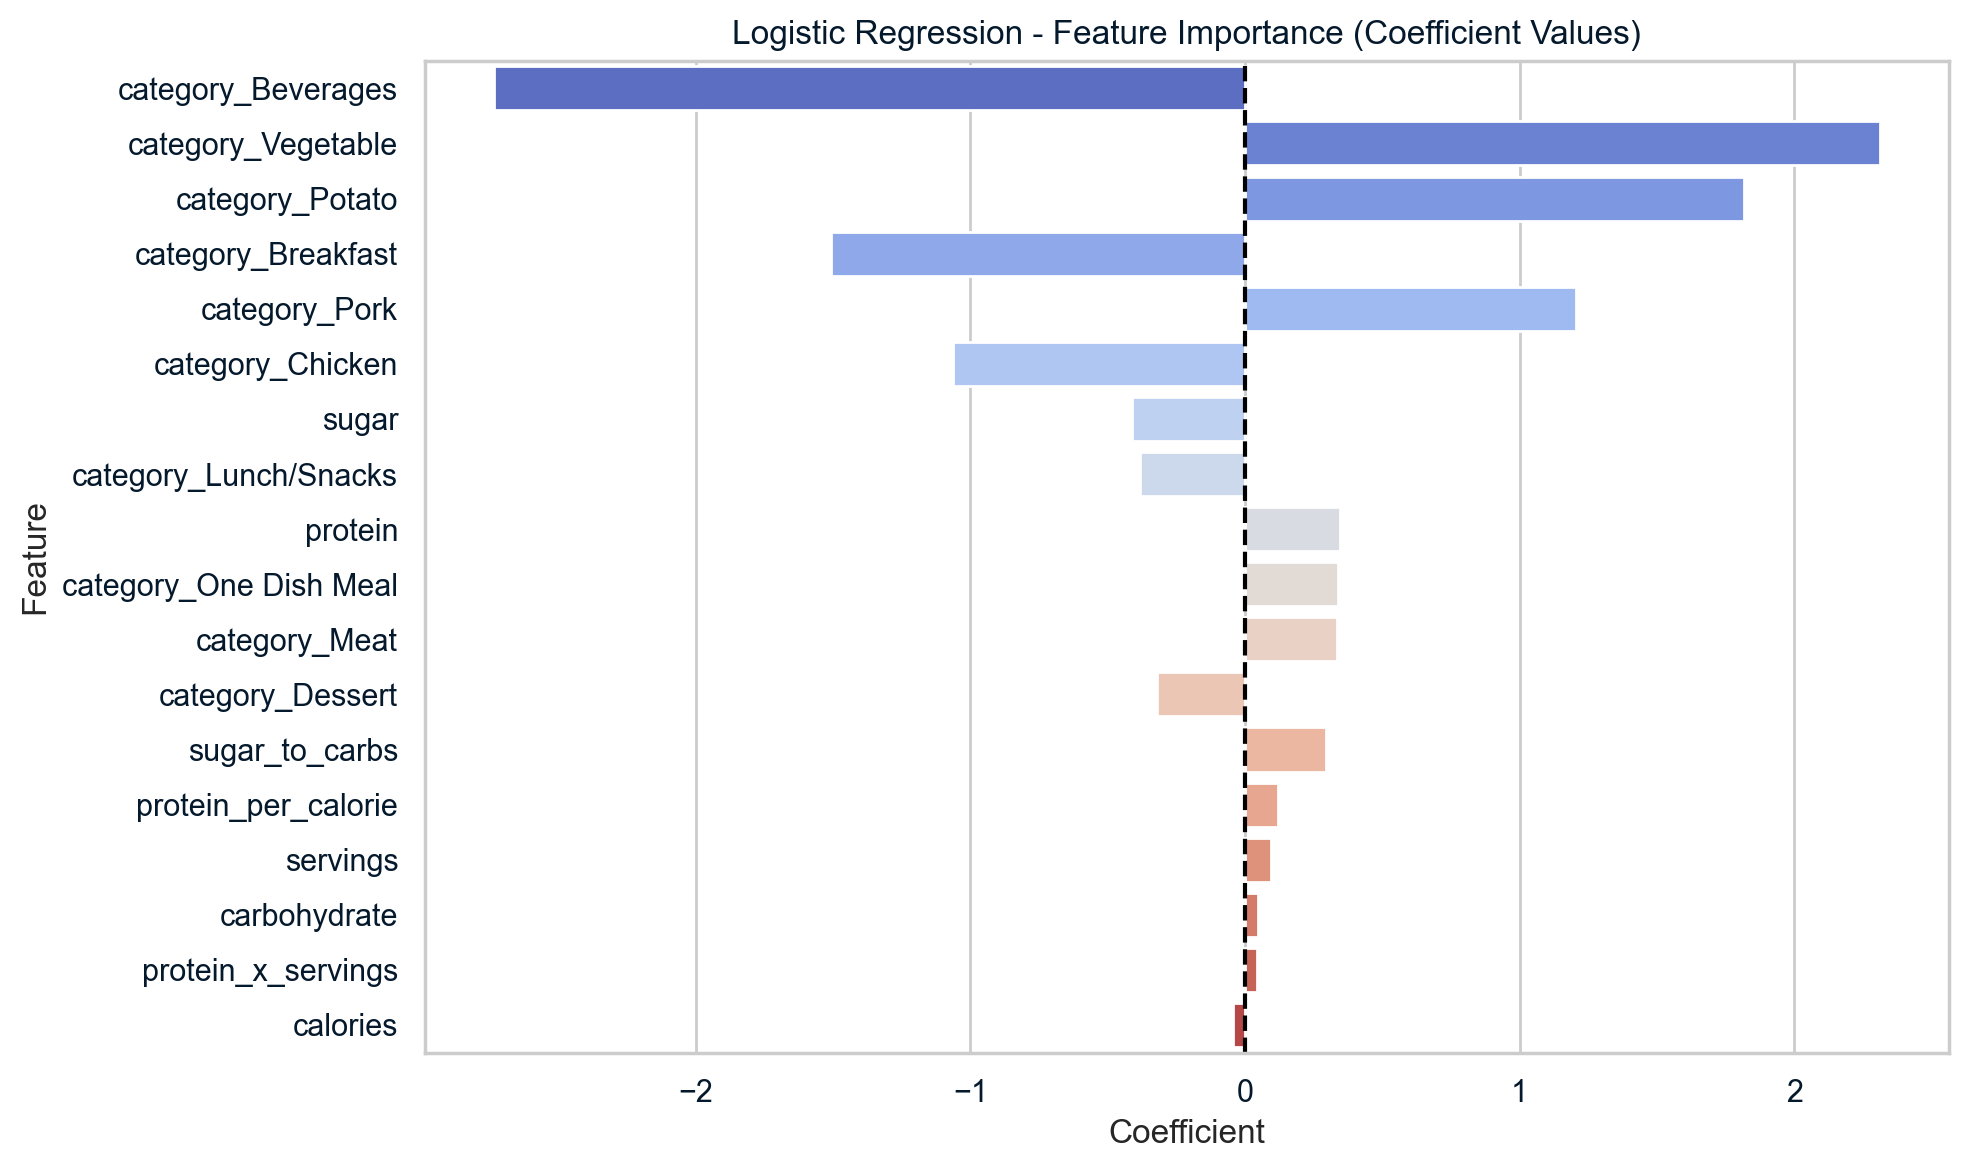

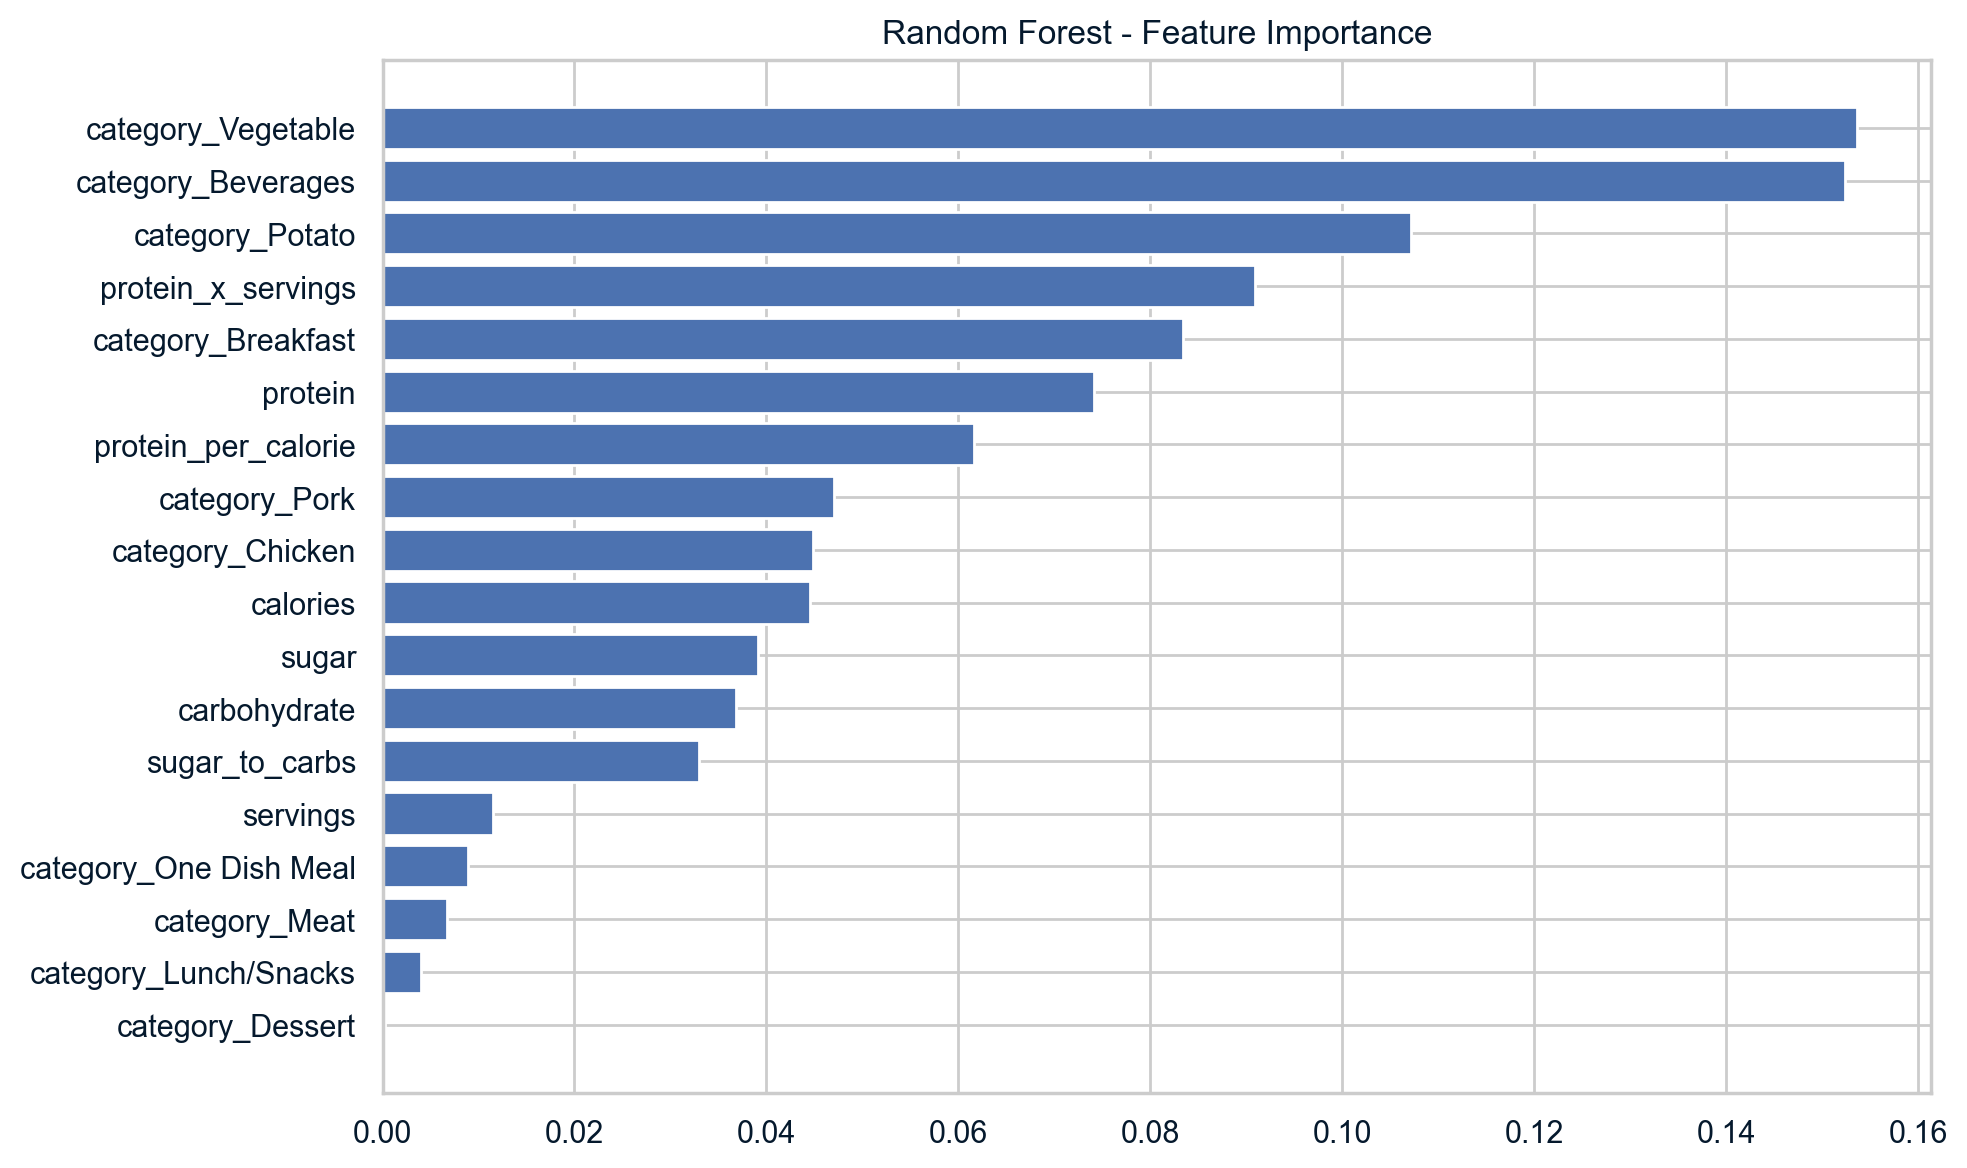

In [77]:
# ================================
# FEATURE IMPORTANCE
# ================================

# Logistic Regression Feature Importance
log_model = fitted_models['Logistic Regression'].named_steps['clf']
# Retrieve encoded categorical feature names from the preprocessing pipeline
encoded_cat_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
# Combine numeric and encoded categorical feature names
final_columns = numeric_features + list(encoded_cat_cols)

# Create a DataFrame with coefficients to understand feature direction and strength
log_imp_df = pd.DataFrame({
    'Feature': final_columns,
    'Coefficient': log_model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Plot coefficients showing both positive and negative contributions
plt.figure(figsize=(10, 6))
sns.barplot(data=log_imp_df, x='Coefficient', y='Feature', palette='coolwarm')
plt.axvline(0, color='black', linestyle='--')  # Neutral reference line
plt.title("Logistic Regression - Feature Importance (Coefficient Values)")
plt.tight_layout()
plt.show()

# Random Forest & XGBoost Feature Importance
# These models measure feature importance by how much each feature reduces impurity or contributes to the model
for name in ['Random Forest', 'XGBoost']:
    clf = fitted_models[name].named_steps['clf']
    importances = clf.feature_importances_
    feat_df = pd.DataFrame({
        'Feature': final_columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feat_df['Feature'], feat_df['Importance'])
    plt.gca().invert_yaxis()  # Flip to match bar chart conventions
    plt.title(f"{name} - Feature Importance")
    plt.tight_layout()
    plt.show()


1. Logistic Regression
Graph: Bar plot with positive and negative coefficients.

What It Shows:

Positive coefficients:

- Features increase the likelihood of high traffic (e.g. category_Vegetable, category_Potato, category_Breakfast).

- Business Insight: These are the categories or numerical features that most strongly influence recipes being successful.

Negative coefficients: 

- Features decrease the likelihood of high traffic (e.g. category_Beverages, sugar_to_carbs, protein_x_servings).

- Business Insight: Recipes with these features are less likely to perform well; might be risky to highlight.

Takeaway: Direction matters here — both strength and sign (+ or -).

2. Random Forest & 3. XGBoost
Graph: Horizontal bar plot showing feature importance scores.

Positive-Only Importance:

- These models measure how much a feature reduces error during splits (impurity reduction).

- Features like category_Vegetable, category_Beverages, and protein_x_servings are consistently at the top — they’re important decision points, but direction (positive/negative) is not shown.

Takeaway:

- Use these models to identify top features for overall impact but rely on Logistic Regression to understand directional impact.


### Model Evaluation: Insights vs Graphs
1. Logistic Regression
    - AUC: 0.85

    - Precision: 0.90 — best of the bunch, meaning it’s super confident when it says “high traffic.”

    - Accuracy: 0.69 — a bit lower since it misses some high-traffic cases (higher false negatives).

    - Key Features: category_Beverages (negative), category_Vegetable (positive), category_Potato (positive).

    - ROC Curve: Best separation of classes, holding strong across thresholds.

    - Takeaway: High precision and top AUC make this the go-to for reducing false positives and prioritizing homepage real estate.
  
2. Random Forest
    - AUC: 0.82

    - Precision: 0.85 — solid, not as high as LR but still strong.

    - Accuracy: 0.74 — better balance with fewer misses (fewer false negatives).

    - Key Features: category_Beverages, category_Vegetable, protein_x_servings.

    - ROC Curve: A bit below LR, but still solid and consistent.

    - Takeaway: If you’re cool with a few more false positives for more high-traffic hits, RF’s your pick.

3. XGBoost
    - AUC: 0.84

    - Precision: 0.84 — competitive, but slightly under LR and RF.

    - Accuracy: 0.75 — edges out RF in raw accuracy, but similar trade-offs.

    - Key Features: category_Beverages, category_Breakfast, category_Chicken.

    - ROC Curve: Steady, good at balancing TPR and FPR.

    - Takeaway: A solid middle ground — edges in accuracy, but not quite as precise as LR. Might be the fallback if RF or LR needs to be tuned.

Logistic Regression
Confusion Matrix:
- [[82  8]
- [62 72]]
Precision Score: 0.90
Accuracy Score: 0.69

Interpretation:

  -  Class 0 (Low Traffic): 82 true negatives, 8 false positives.

  -  Class 1 (High Traffic): 62 false negatives, 72 true positives.

  -  High precision (0.90) shows strong confidence in high traffic predictions (fewer false positives).

  -  Accuracy is moderate (0.69) — good at precision, but at the cost of missing some high-traffic cases.

Random Forest
Confusion Matrix:

- [[74 16]
- [42 92]]

Precision Score: 0.85
Accuracy Score: 0.74

Interpretation:

    Precision (0.85) is solid but slightly lower than Logistic Regression.

    Accuracy (0.74) is higher — Random Forest captures more true positives but with more false positives (16 vs. 8).

XGBoost 
Confusion Matrix:

- [[72 18]
- [39 95]]
  
Precision Score: 0.84
Accuracy Score: 0.75

Interpretation:

    Similar to Random Forest — slightly better accuracy (0.75) but a bit lower precision (0.84).

    Captures more true positives (95) but at the cost of more false positives (18).

Overall Results
Summary:

✅ Logistic Regression nails the precision game (0.90), making it the top choice for production if your priority is minimizing false positives (wasted homepage slots).
✅ Random Forest is a reliable runner-up: it captures more true positives and achieves higher accuracy but tolerates slightly more false positives — a trade-off if you want broader coverage.
✅ XGBoost edges out both in accuracy (0.75) but has slightly lower precision (0.84) — a solid middle ground if you’re balancing between precision and recall.
💡 Key takeaway:
If you want super clean homepage selections with fewer false positives, Logistic Regression wins. If you’re okay with a bit more risk for more high-traffic recipes, Random Forest and XGBoost are solid backups.



In [ ]:
# Define threshold for consistent evaluation
threshold = 0.52
predictions = {}

from sklearn.metrics import precision_score, accuracy_score

def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Evaluate a model's predictions and return key metrics.
    
    Args:
        y_true: Ground truth labels
        y_pred: Model predictions
        model_name: Name of the model (optional)
    
    Returns:
        A dictionary containing precision and accuracy.
    """
    precision = precision_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    print(f"--- {model_name} Evaluation ---")
    print(f"Precision: {precision:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    
    return {
        "Model": model_name,
        "Precision": precision,
        "Accuracy": accuracy
    }

for model_name in ['Logistic Regression', 'XGBoost', 'Random Forest']:
    X_trans = fitted_models[model_name].named_steps['preprocess'].transform(X_test)
    y_proba = fitted_models[model_name].named_steps['clf'].predict_proba(X_trans)[:, 1]
    predictions[model_name] = (y_proba >= threshold).astype(int)


# Now call evaluation function
metrics_dict = {}
for model_name, preds in predictions.items():
    metrics_dict[model_name] = evaluate_model(y_test, preds, model_name)




Logistic Regression Metrics:
Precision: 0.90 (Goal: ≥0.80) – critical KPI to avoid wasting homepage space
Accuracy: 0.69 – overall correctness
Recall: 0.54 – ensures model captures most high-traffic recipes
F1 Score: 0.67 – balance between precision and recall
Business Baseline: 60% accuracy (current approach) – model must exceed this.
✅ Precision meets/exceeds the business goal!

XGBoost Metrics:
Precision: 0.84 (Goal: ≥0.80) – critical KPI to avoid wasting homepage space
Accuracy: 0.75 – overall correctness
Recall: 0.71 – ensures model captures most high-traffic recipes
F1 Score: 0.77 – balance between precision and recall
Business Baseline: 60% accuracy (current approach) – model must exceed this.
✅ Precision meets/exceeds the business goal!

Random Forest Metrics:
Precision: 0.85 (Goal: ≥0.80) – critical KPI to avoid wasting homepage space
Accuracy: 0.74 – overall correctness
Recall: 0.69 – ensures model captures most high-traffic recipes
F1 Score: 0.76 – balance between precision

In [ ]:
# ==============================
# Business Metrics to Monitor
# ==============================

metrics_df = pd.DataFrame(metrics_dict.values(), index=metrics_dict.keys())

print("\nModel Metrics Summary:")
print(metrics_df)

# Plot Precision and Accuracy for easier business monitoring
import matplotlib.pyplot as plt

metrics_df[['Precision', 'Accuracy']].plot(kind='bar', figsize=(10, 6), ylim=(0, 1), color=['skyblue', 'salmon'])
plt.axhline(y=0.80, color='red', linestyle='--', label='Precision Goal (0.80)')
plt.ylabel('Score')
plt.title('Model Precision and Accuracy Comparison')
plt.legend()
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Model Metrics Summary:
                     Precision  Accuracy    Recall  F1 Score
Logistic Regression   0.900000  0.687500  0.537313  0.672897
XGBoost               0.840708  0.745536  0.708955  0.769231
Random Forest         0.851852  0.741071  0.686567  0.760331


Final Summary & Recommendations

Model Performance Recap

    Logistic Regression leads with 90% precision, exceeding the 0.80 business goal but at the cost of lower recall (0.54) and moderate accuracy (0.69).

    Random Forest balances strong precision (0.85) with better recall (0.69) and higher accuracy (0.74).

    XGBoost is consistent (0.84 precision, 0.75 accuracy) but doesn't outperform the others.

Top Features Driving Predictions

    Nutritional: Protein (log-transformed) and Calories.

    Categorical: Vegetable, Potato, and Pork recipes stand out as traffic magnets.

Recommendation
- ✅ Deploy Logistic Regression as the production model if the main priority is avoiding false positives and saving homepage space.
- ✅ Use Random Forest as a secondary model if you're okay with a few more false positives in exchange for better recall (finding more high-traffic recipes).
- ✅ Optimize content by focusing on protein-rich, higher-calorie recipes in top categories like Vegetables, Potatoes, and Pork.
- ✅ Weekly monitoring of precision and recall to adjust thresholds as needed — marketing demands may shift!

Final Summary & Recommendations

Model Performance Recap

    Logistic Regression leads with 90% precision, exceeding the 0.80 business goal but at the cost of lower recall (0.54) and moderate accuracy (0.69).

    Random Forest balances strong precision (0.85) with better recall (0.69) and higher accuracy (0.74).

    XGBoost is consistent (0.84 precision, 0.75 accuracy) but doesn't outperform the others.

Top Features Driving Predictions

    Nutritional: Protein (log-transformed) and Calories.

    Categorical: Vegetable, Potato, and Pork recipes stand out as traffic magnets.

Recommendation
- ✅ Deploy Logistic Regression as the production model if the main priority is avoiding false positives and saving homepage space.
- ✅ Use Random Forest as a secondary model if you're okay with a few more false positives in exchange for better recall (finding more high-traffic recipes).
- ✅ Optimize content by focusing on protein-rich, higher-calorie recipes in top categories like Vegetables, Potatoes, and Pork.
- ✅ Weekly monitoring of precision and recall to adjust thresholds as needed — marketing demands may shift!

In [ ]:
# Demo: Predictive Function

# This function uses the Logistic Regression model to predict whether a given recipe will result in HIGH or NORMAL website traffic.

try:
    # Check if X_test exists
    if 'X_test' not in globals():
        raise NameError("X_test is not defined. Please run the data split and define X_test.")
    
    # Prompt the user for a Recipe ID
    recipe_id_input = input(f"Enter Recipe ID (0 to {len(X_test)-1}): ").strip()
    recipe_id = int(recipe_id_input)
    
    # Validate Recipe ID range
    if recipe_id < 0 or recipe_id >= len(X_test):
        raise IndexError("Recipe ID out of range")
    
    # Select the row from the test set
    X_query = X_test.iloc[[recipe_id]]
    
    # Apply the preprocessing pipeline
    X_query_transformed = fitted_models['Logistic Regression'].named_steps['preprocess'].transform(X_query)
    
    # Predict using Logistic Regression
    y_pred_query = fitted_models['Logistic Regression'].named_steps['clf'].predict(X_query_transformed)
    
    # Print the result
    if y_pred_query[0] == 1:
        print("🚀 This recipe will likely produce HIGH TRAFFIC!")
    else:
        print("🔍 This recipe will likely produce NORMAL TRAFFIC.")

except ValueError:
    print("⚠️ Invalid input. Please enter a valid integer for the Recipe ID.")
except IndexError as e:
    print(f"⚠️ {e}. Please enter a Recipe ID between 0 and {len(X_test)-1}.")
except NameError as e:
    print(f"⚠️ {e} Please make sure you've run the data split and model training steps.")

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation